In [26]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *


"""
Plots we want:
    - more plans being explored in each template when prioritizing
    - final qerr on the worst / best queries
        - hypothesis: worst jerr queries, prioritization will actually improve qerr
    - plot evolution of qerr vs jerr side by side for some queries
    - is each ideal plan in the explored plans at least once?
"""
RES_DIR = "./all_results/cost_models_debug_set"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def update_alg_name(df, cols):
    df['alg_name'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [28]:
COLS = ["loss_func", "cost_model"]

In [29]:
# FIXME: this is really slow
all_df = get_all_training_df(RES_DIR)

In [30]:
update_alg_name(all_df, COLS)
df = all_df[all_df["template"] == "all"]
df = df[df["num_tables"] == "all"]
df = df[df["summary_type"] == "mean"]

all_df = all_df[all_df["template"] != "all"]
all_df = all_df[all_df["summary_type"] == "mean"]

print(set(df["alg_name"]))
print(set(all_df["alg_name"]))

{'flow_loss2_nested_loop_index3', 'flow_loss2_nested_loop_index4', 'flow_loss2_nested_loop_index2', 'flow_loss2_nested_loop_index'}
{'flow_loss2_nested_loop_index3', 'flow_loss2_nested_loop_index4', 'flow_loss2_nested_loop_index2', 'flow_loss2_nested_loop_index'}


In [36]:
HUE_COLORS = {'flow_loss2_nested_loop_index2':'red', \
              'flow_loss2_nested_loop_index3':'blue',  \
              'flow_loss2_nested_loop_index4': 'green',\
              'flow_loss2_nested_loop_index': 'black'}

# Models

## Names follow the format: {loss_func}_{cost_model}

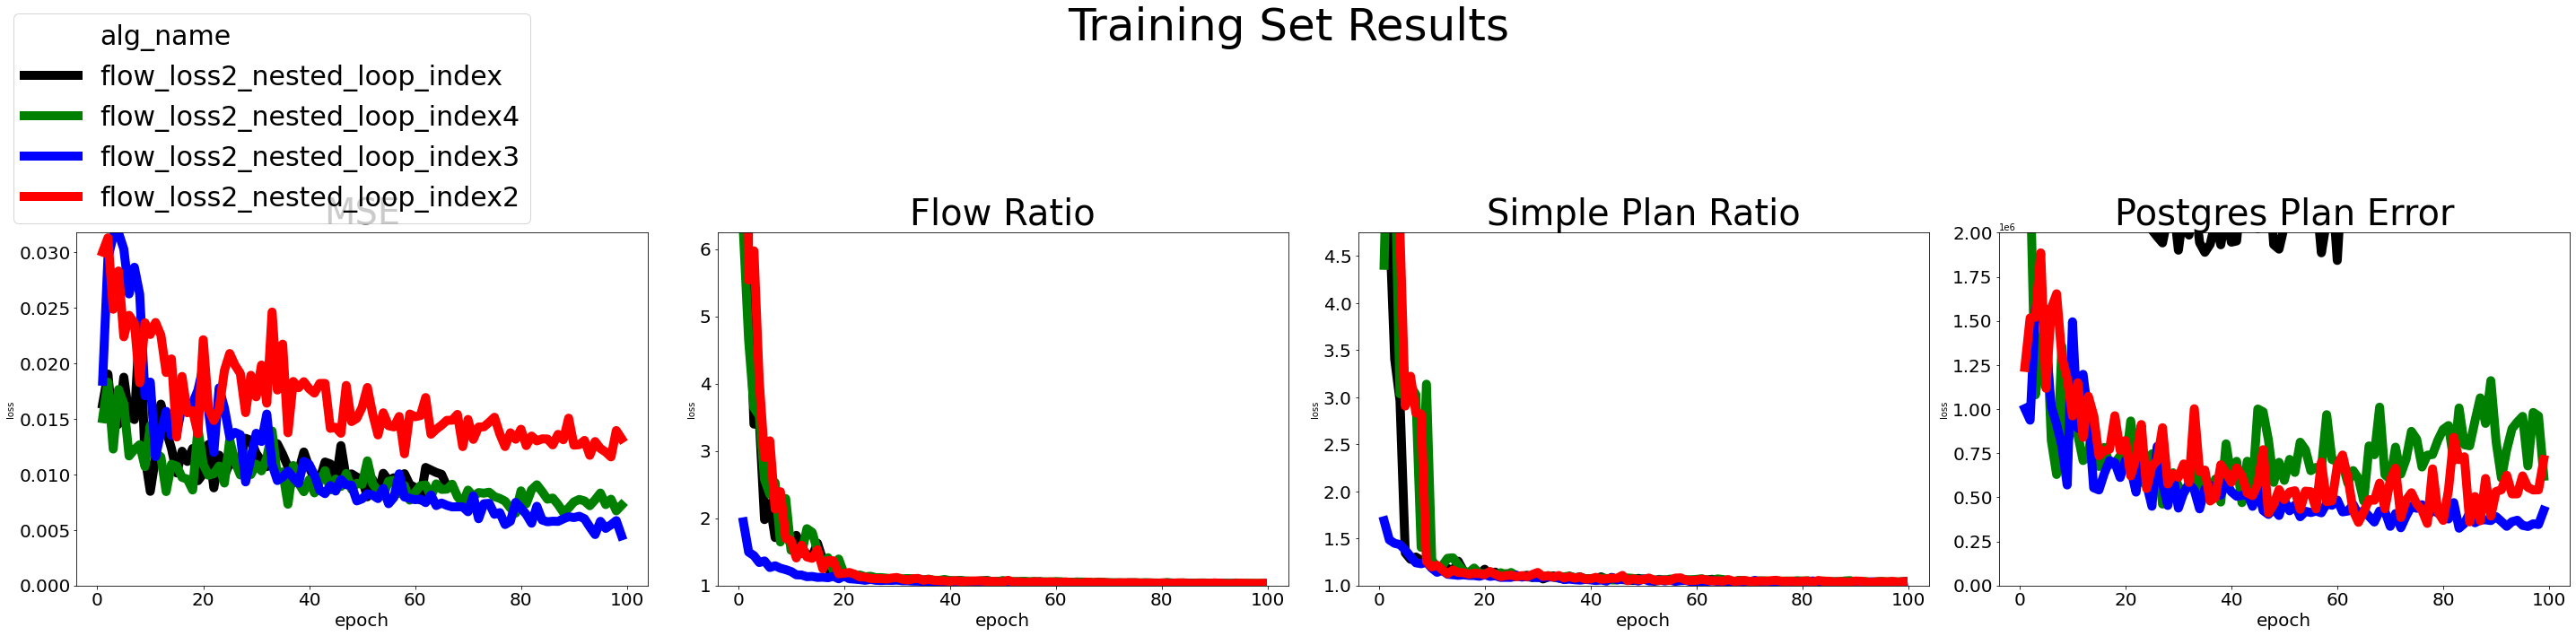

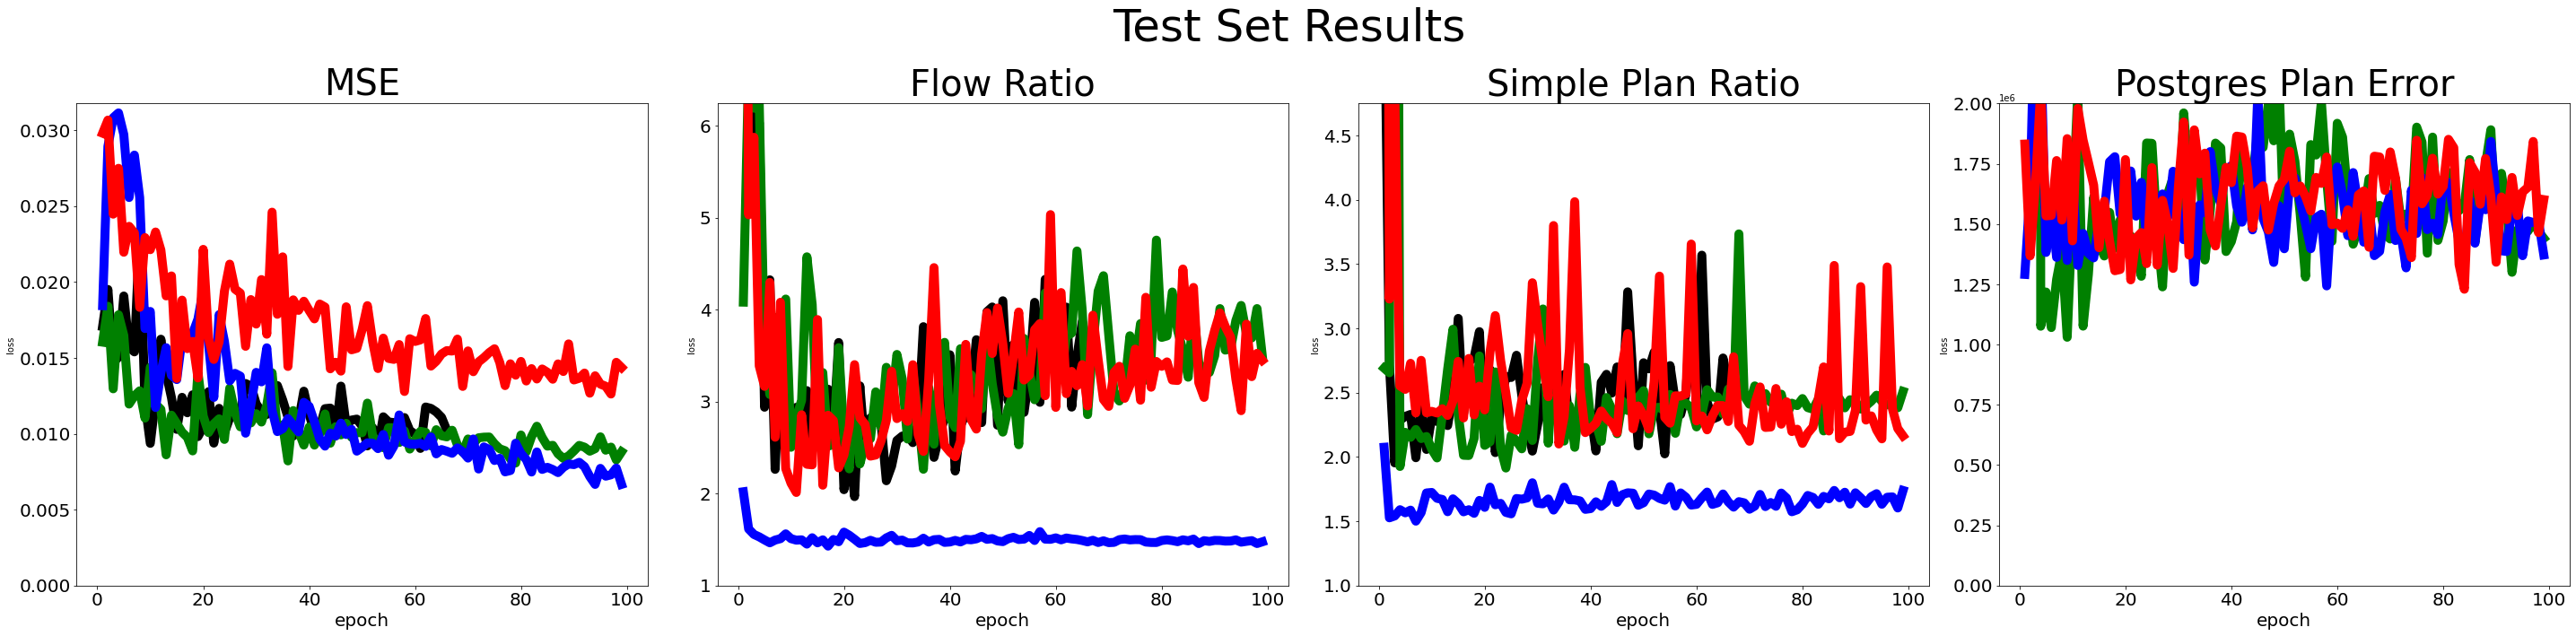

In [37]:
construct_summary(df, "train", "Training Set Results", HUE_COLORS=HUE_COLORS)
construct_summary(df, "test", "Test Set Results", HUE_COLORS=HUE_COLORS)

# Gradients wrt Model Parameters (per layer)

* Each column represents a different "layer", 10 layers because:
    * 4 independent fully connected NN, with 1 hidden layer for Table Features, Join Features, Predicate Features, and Flow Features
    * 2 final layers which combines the output of the ones before
* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step
* Plotted separately for models because scales somewhat different (not sure...why?!)

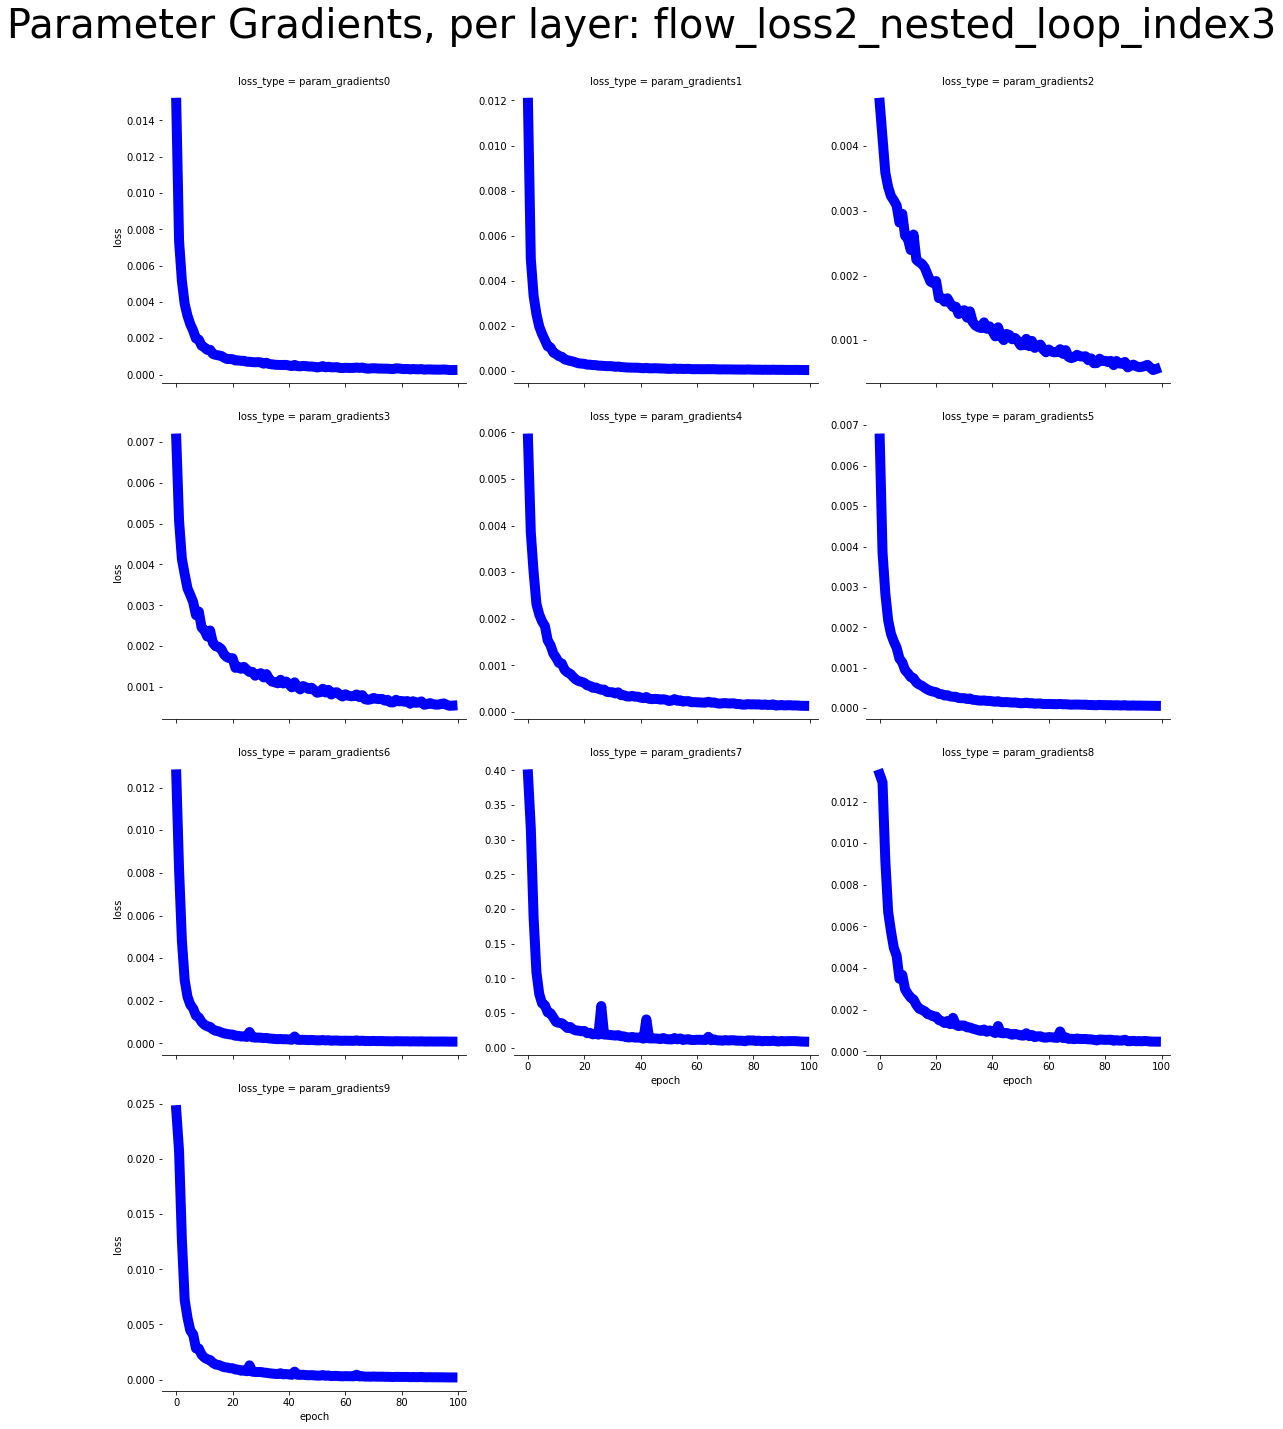

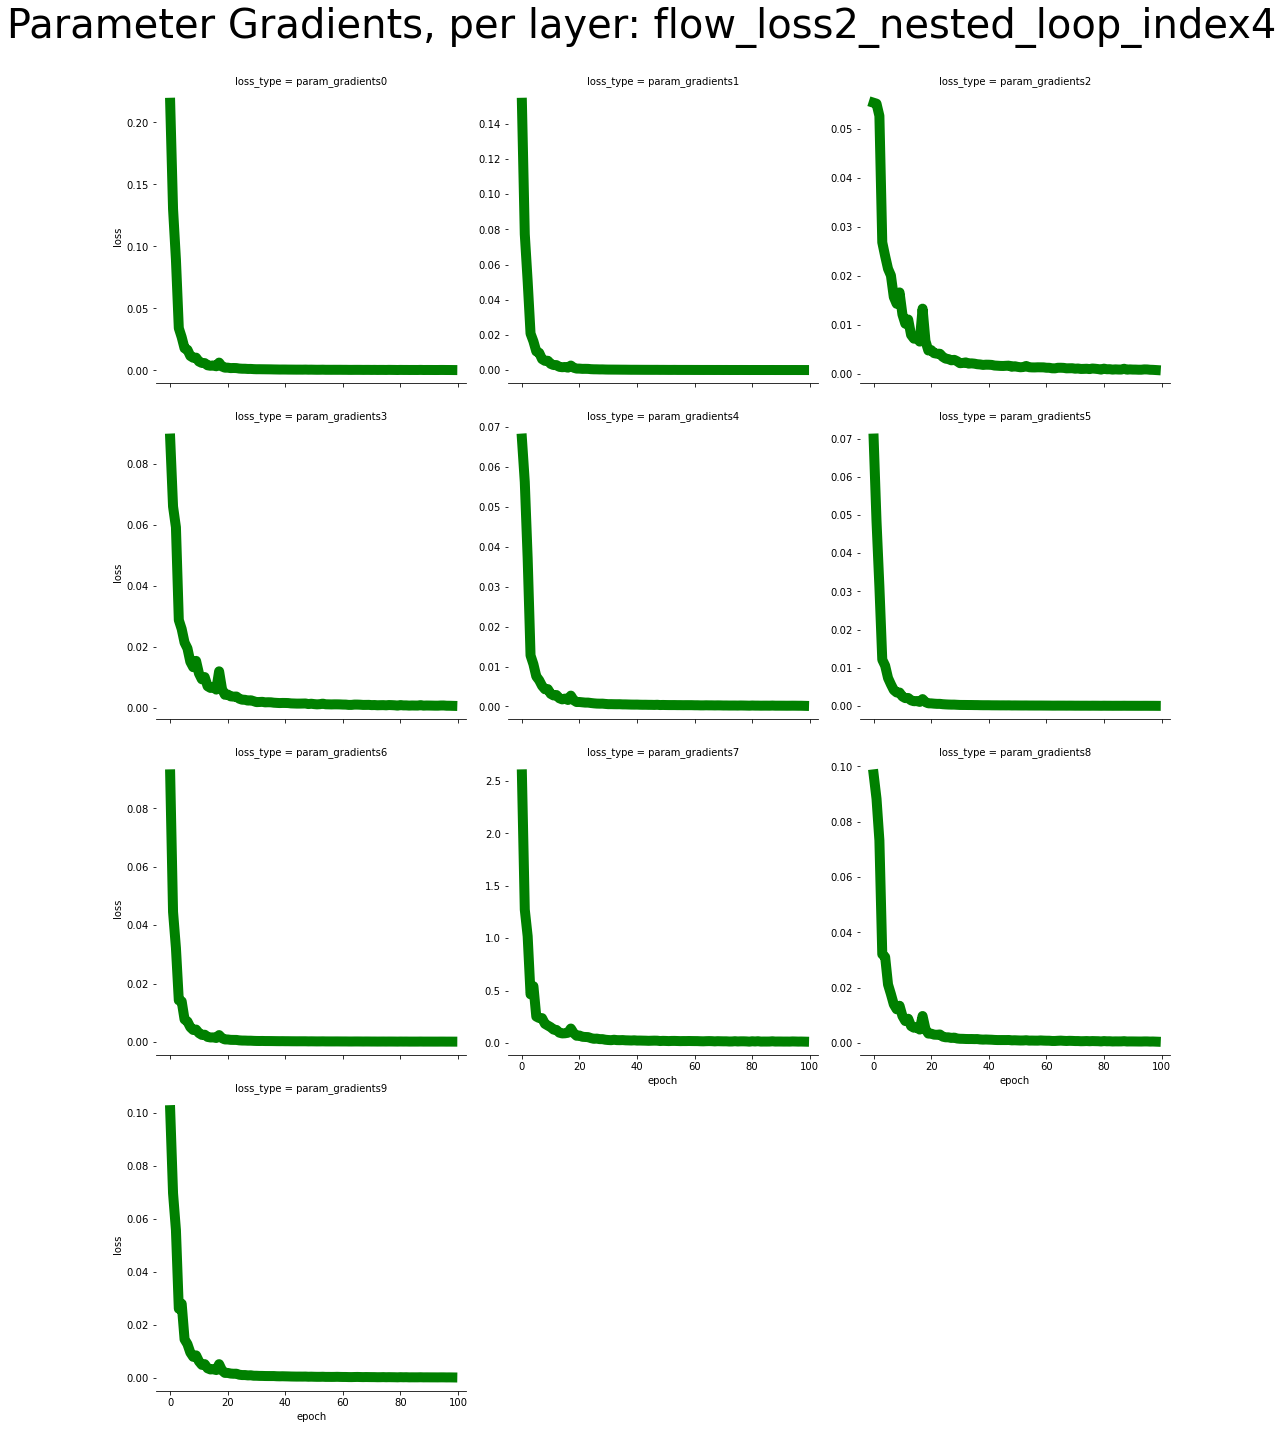

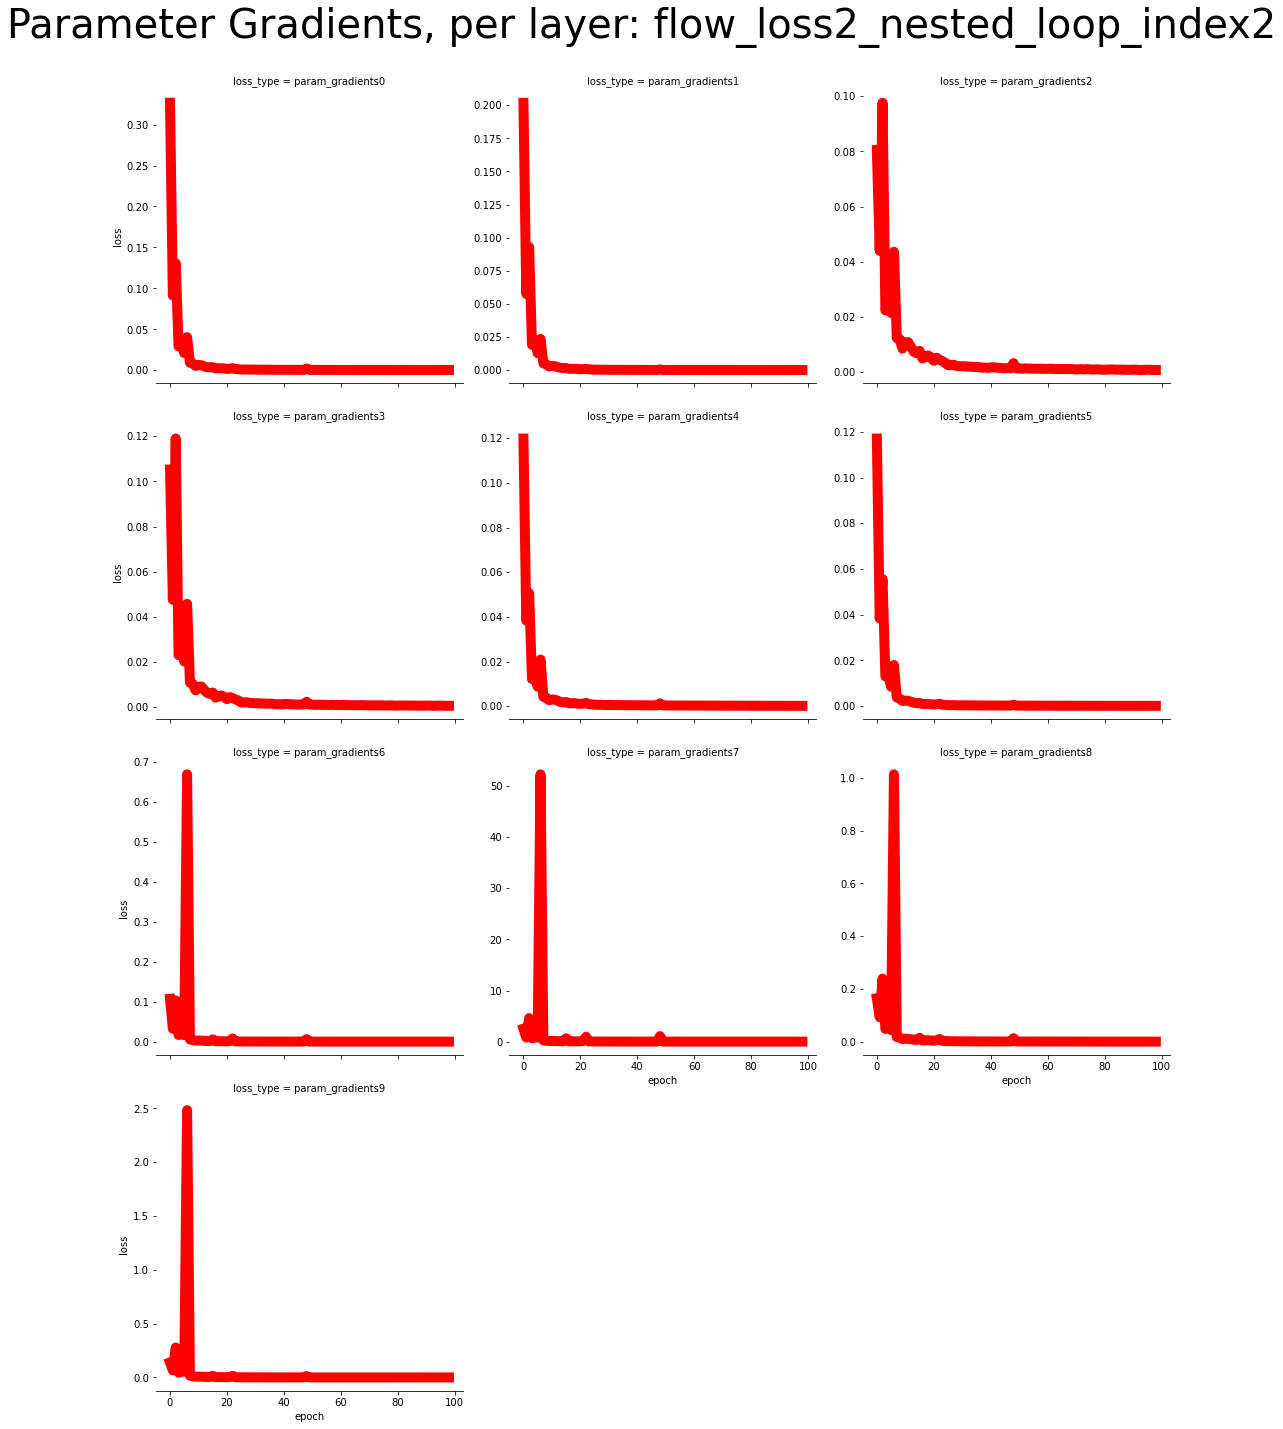

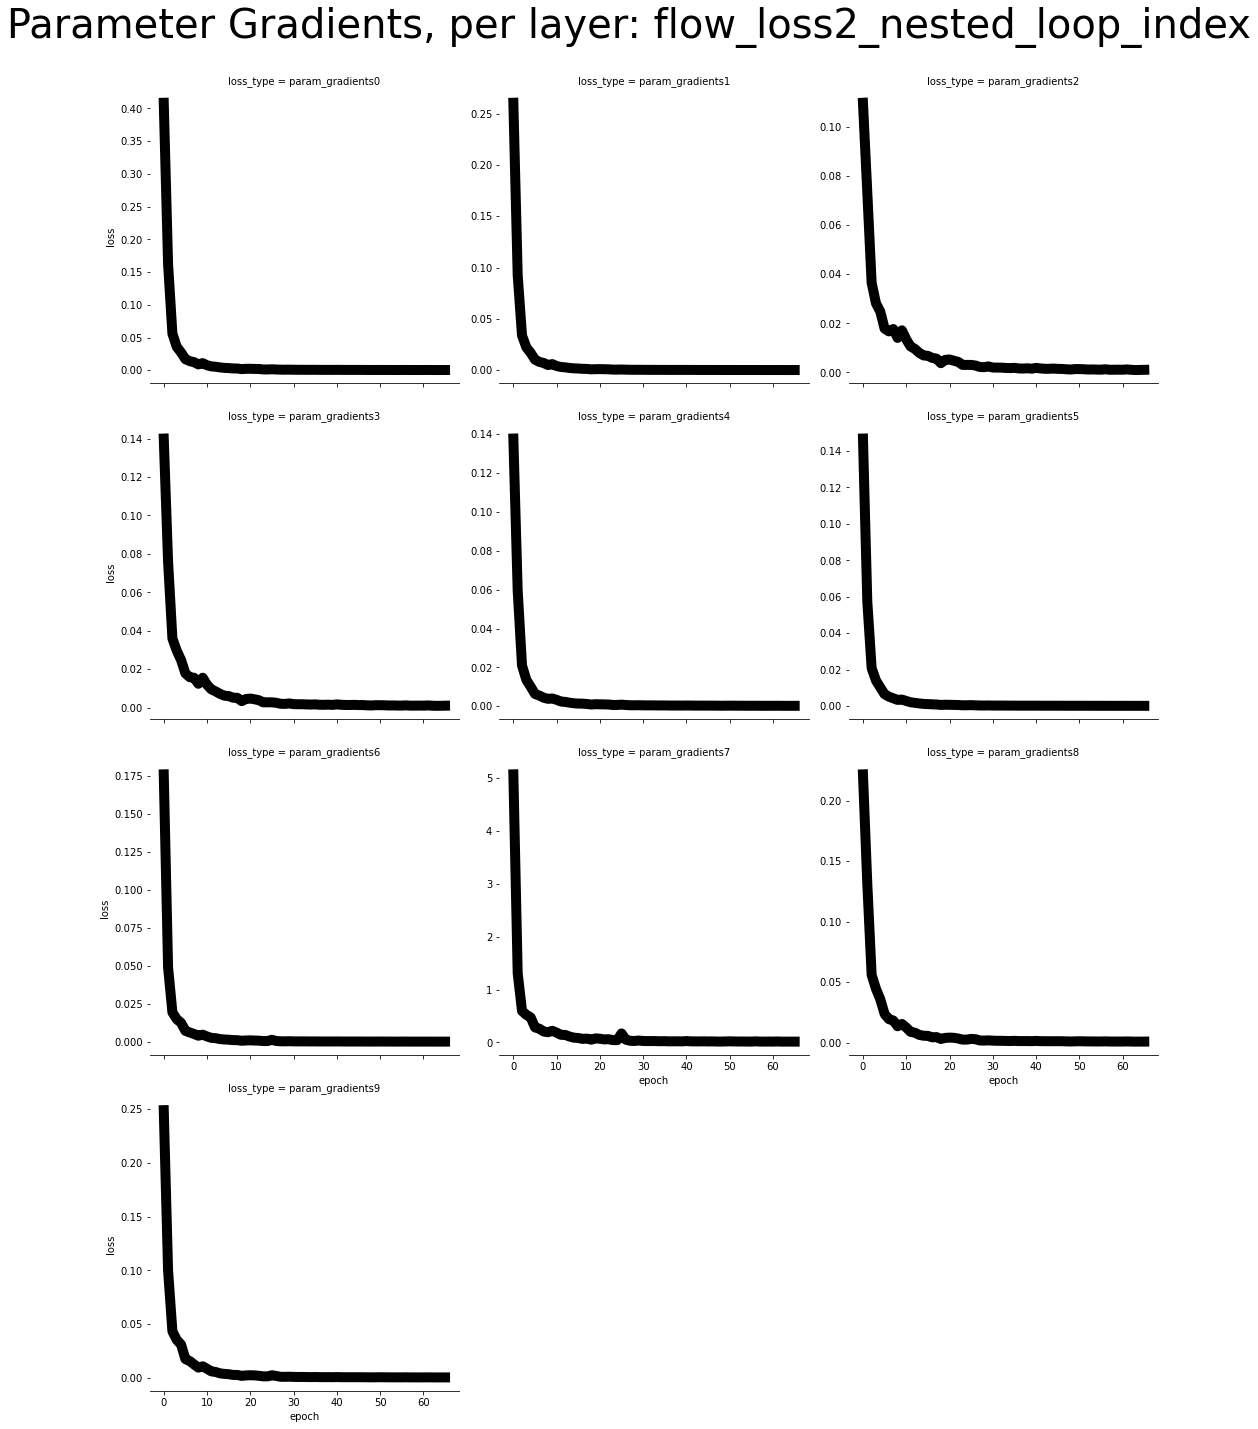

In [38]:
param_gradients =  [g for g in set(df["loss_type"]) if "param" in g]
param_gradients.sort()
par_grad_df = df[df["loss_type"].isin(param_gradients)]
algs = set(par_grad_df["alg_name"])
for alg in algs:
    plot_alg_grad(par_grad_df, alg, HUE_COLORS=HUE_COLORS)

# Gradients wrt Model Parameters (per template)

* Each column represents a different template. (so averaging across all layers)
* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step

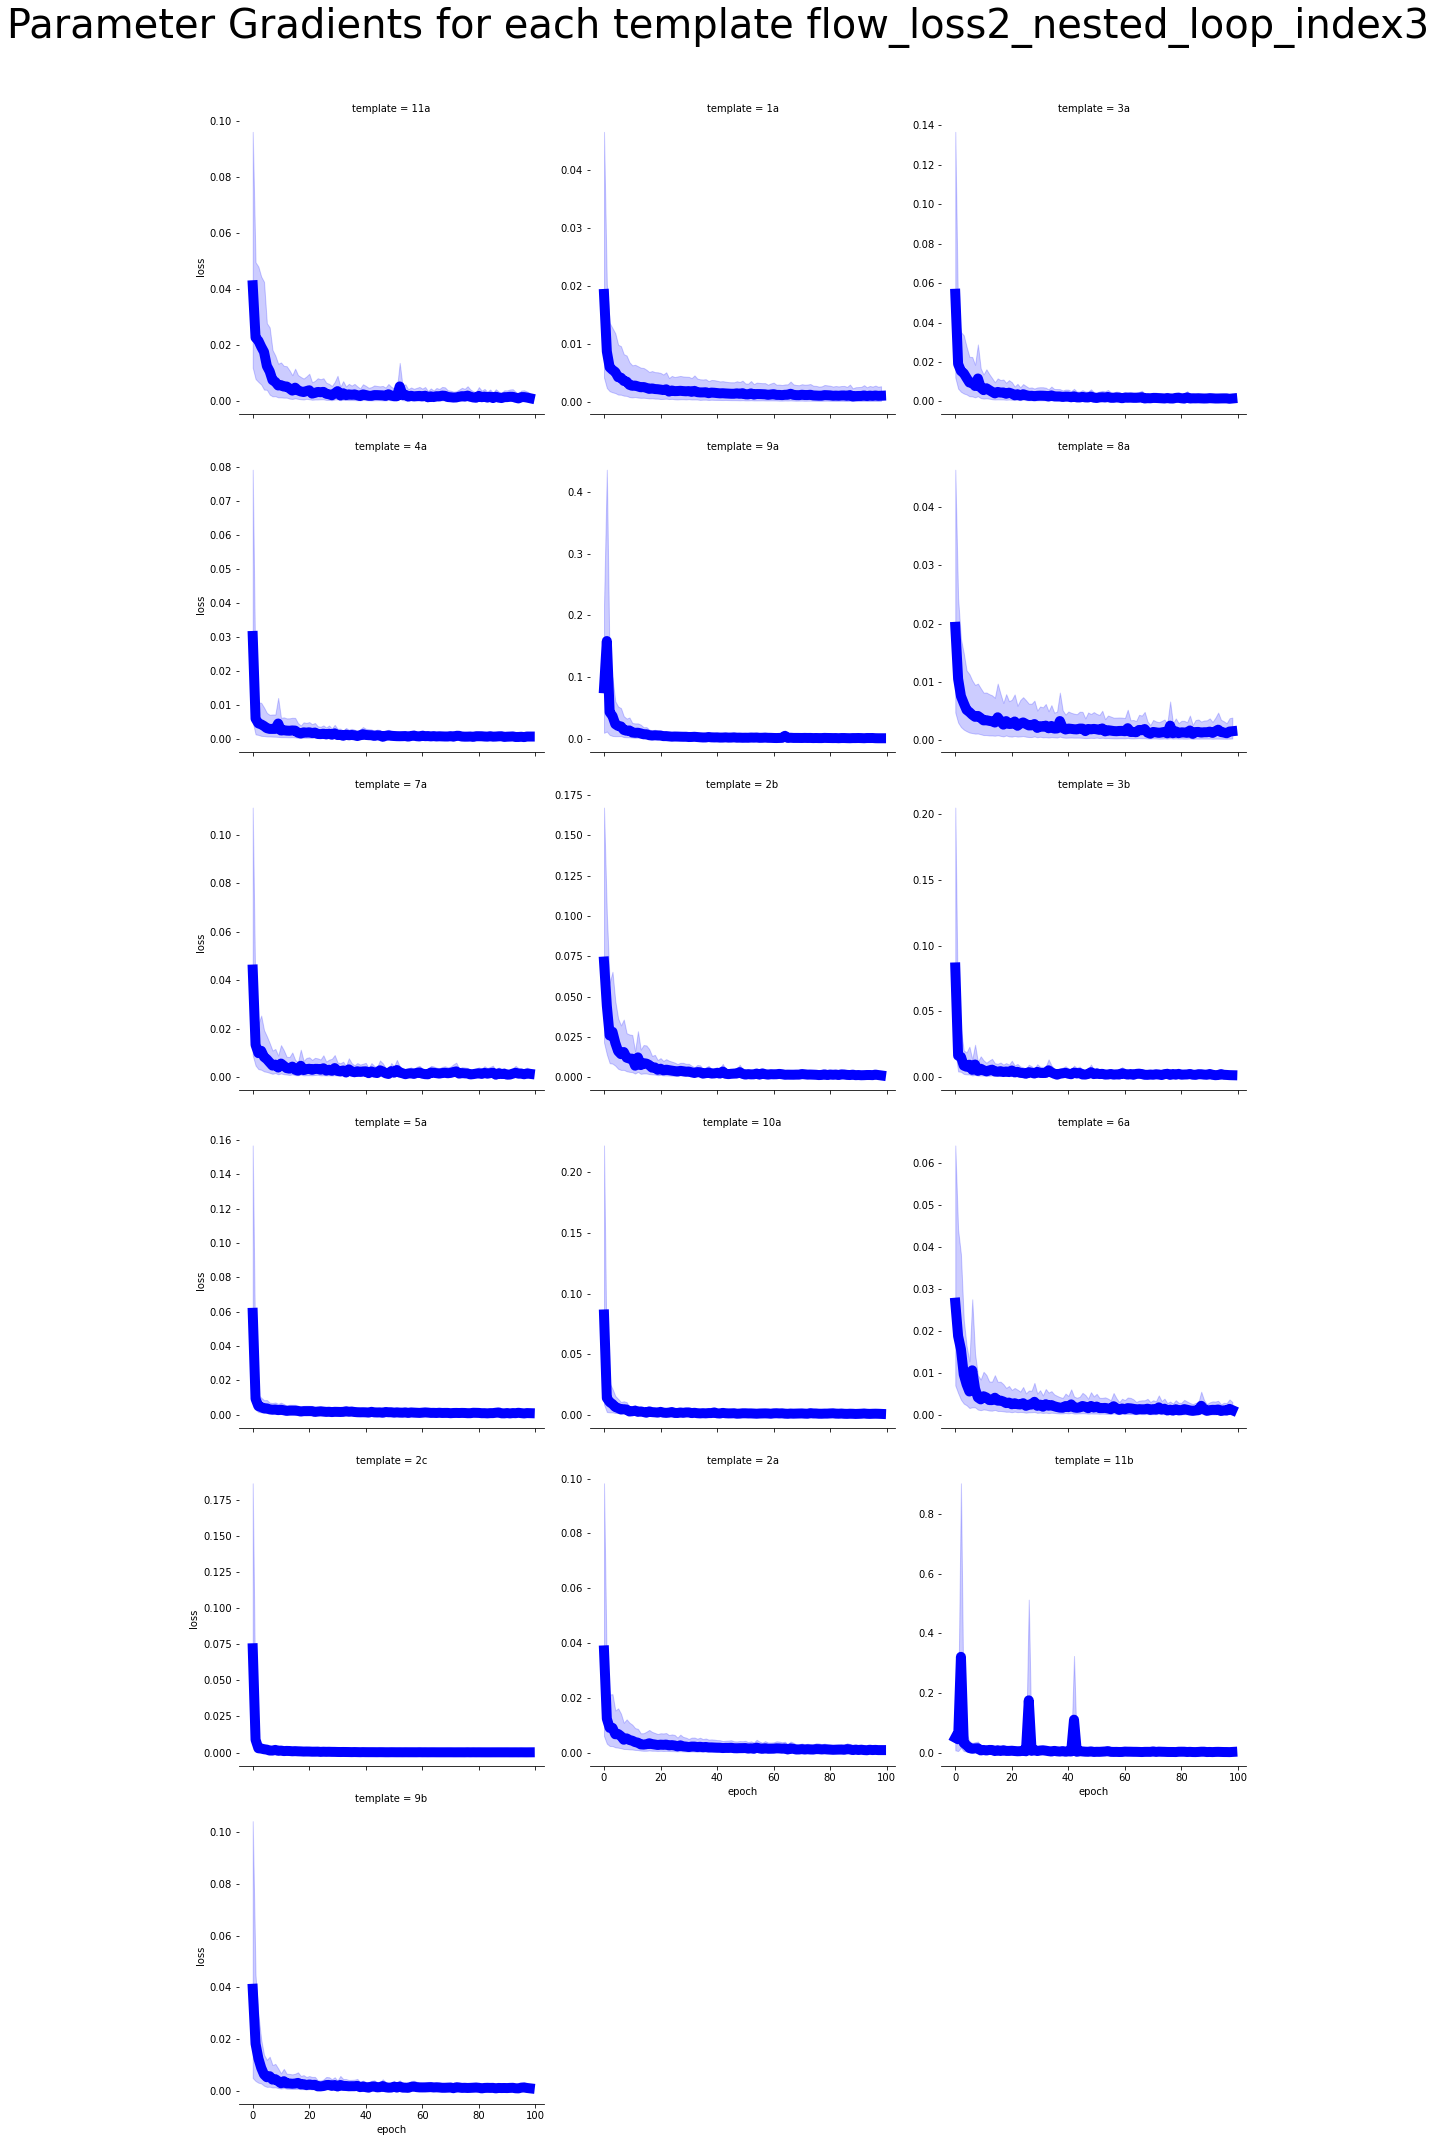

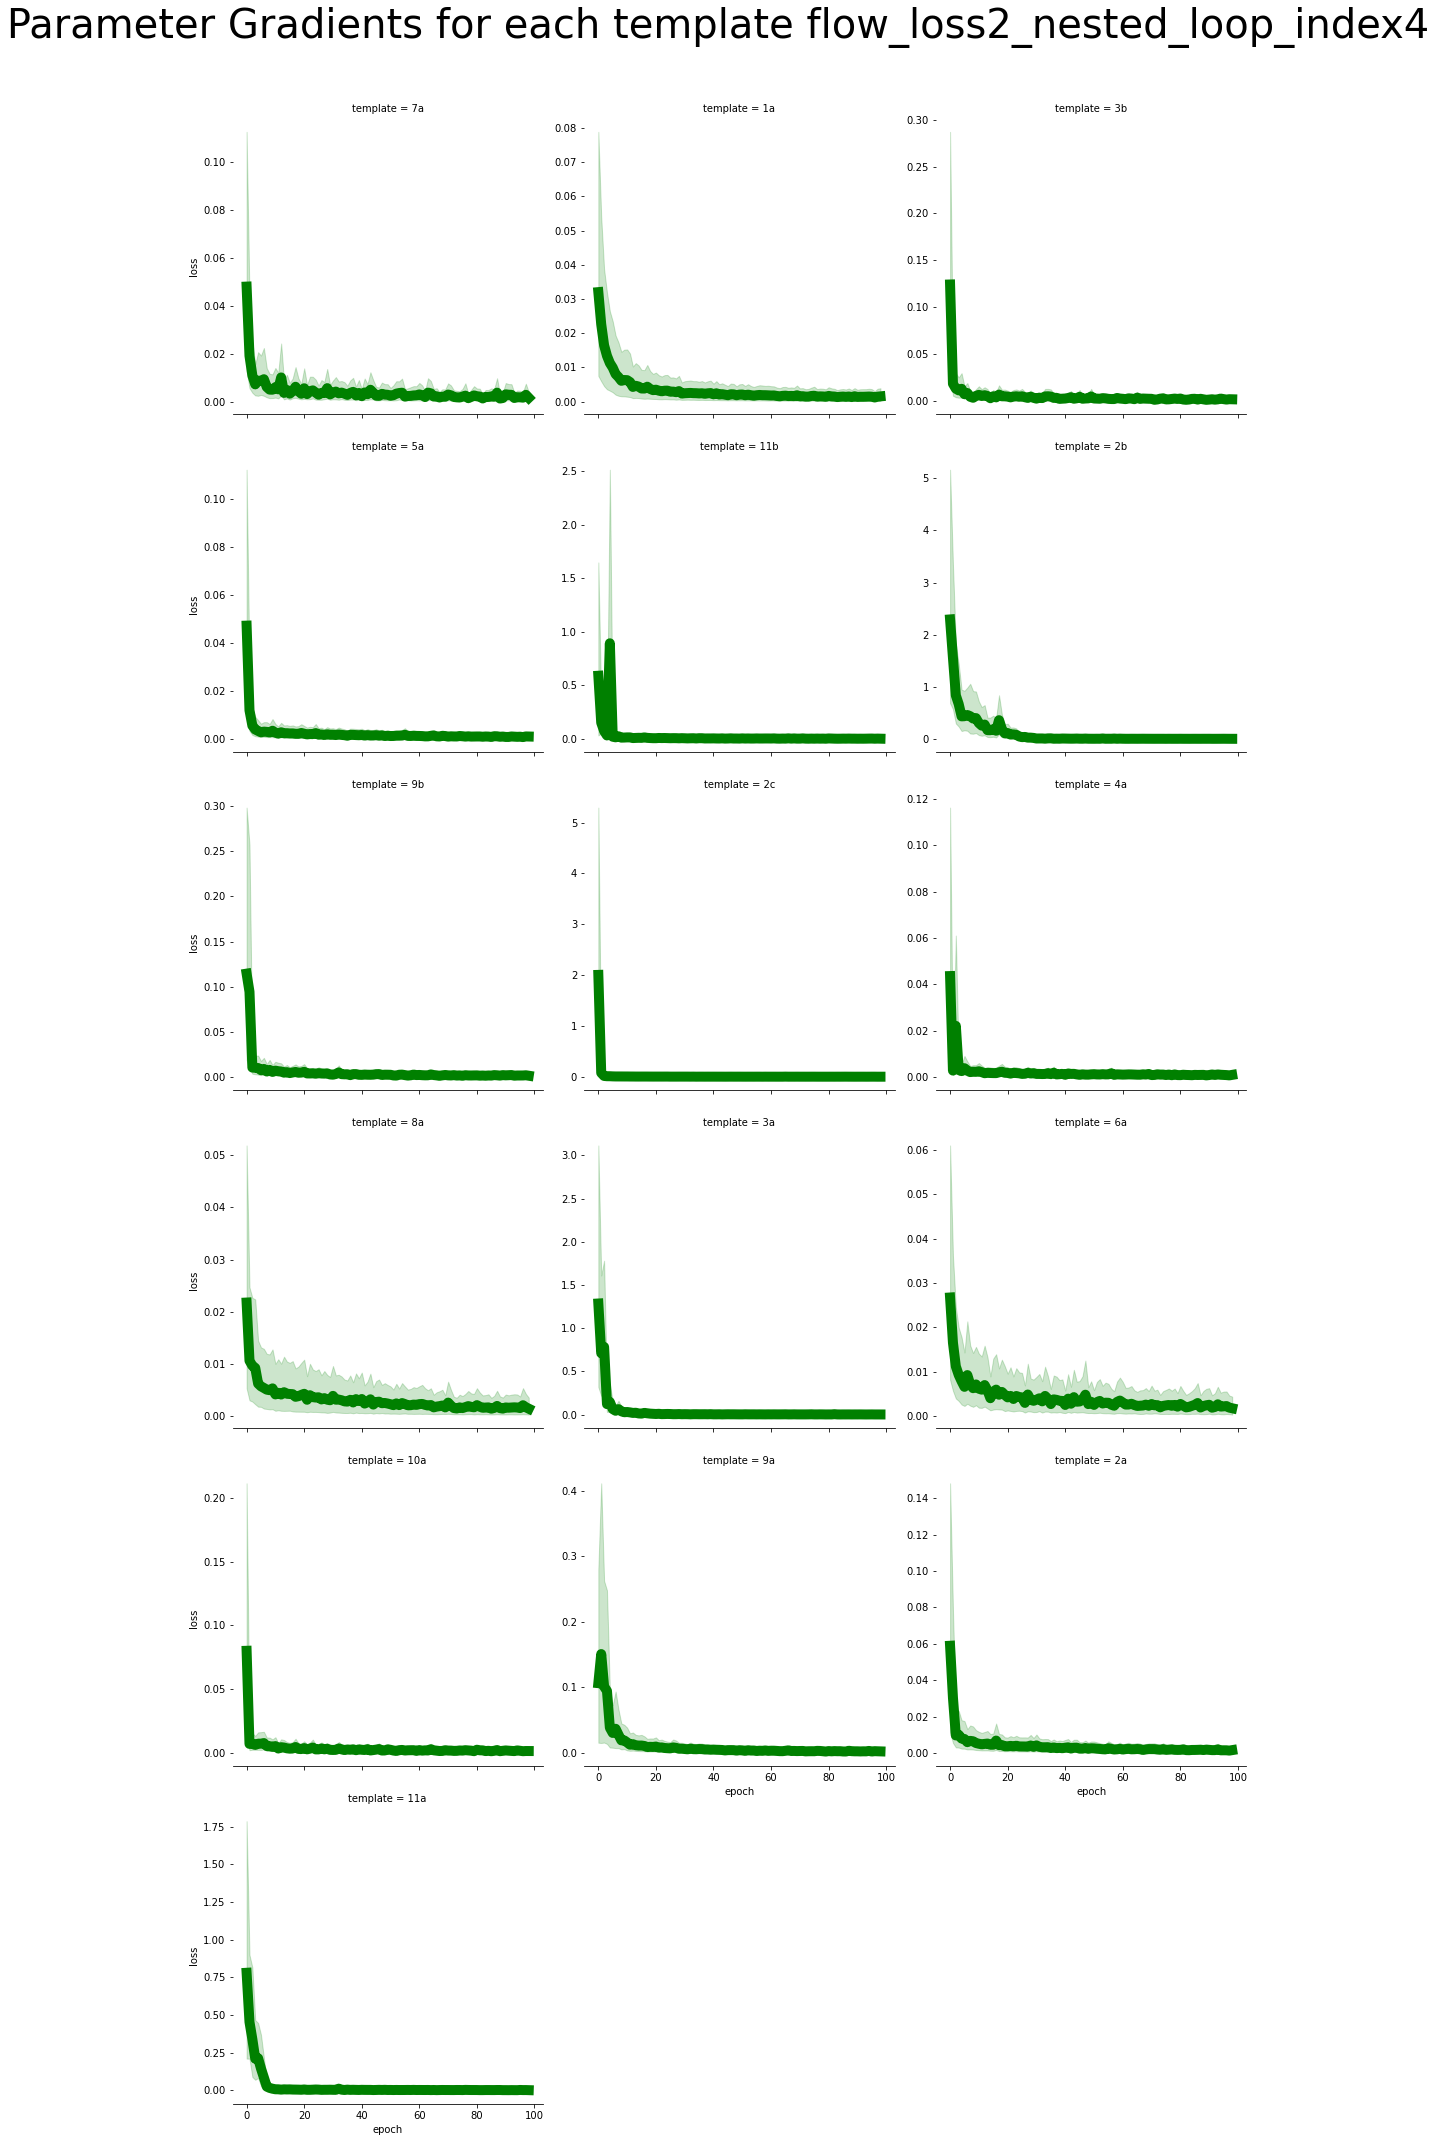

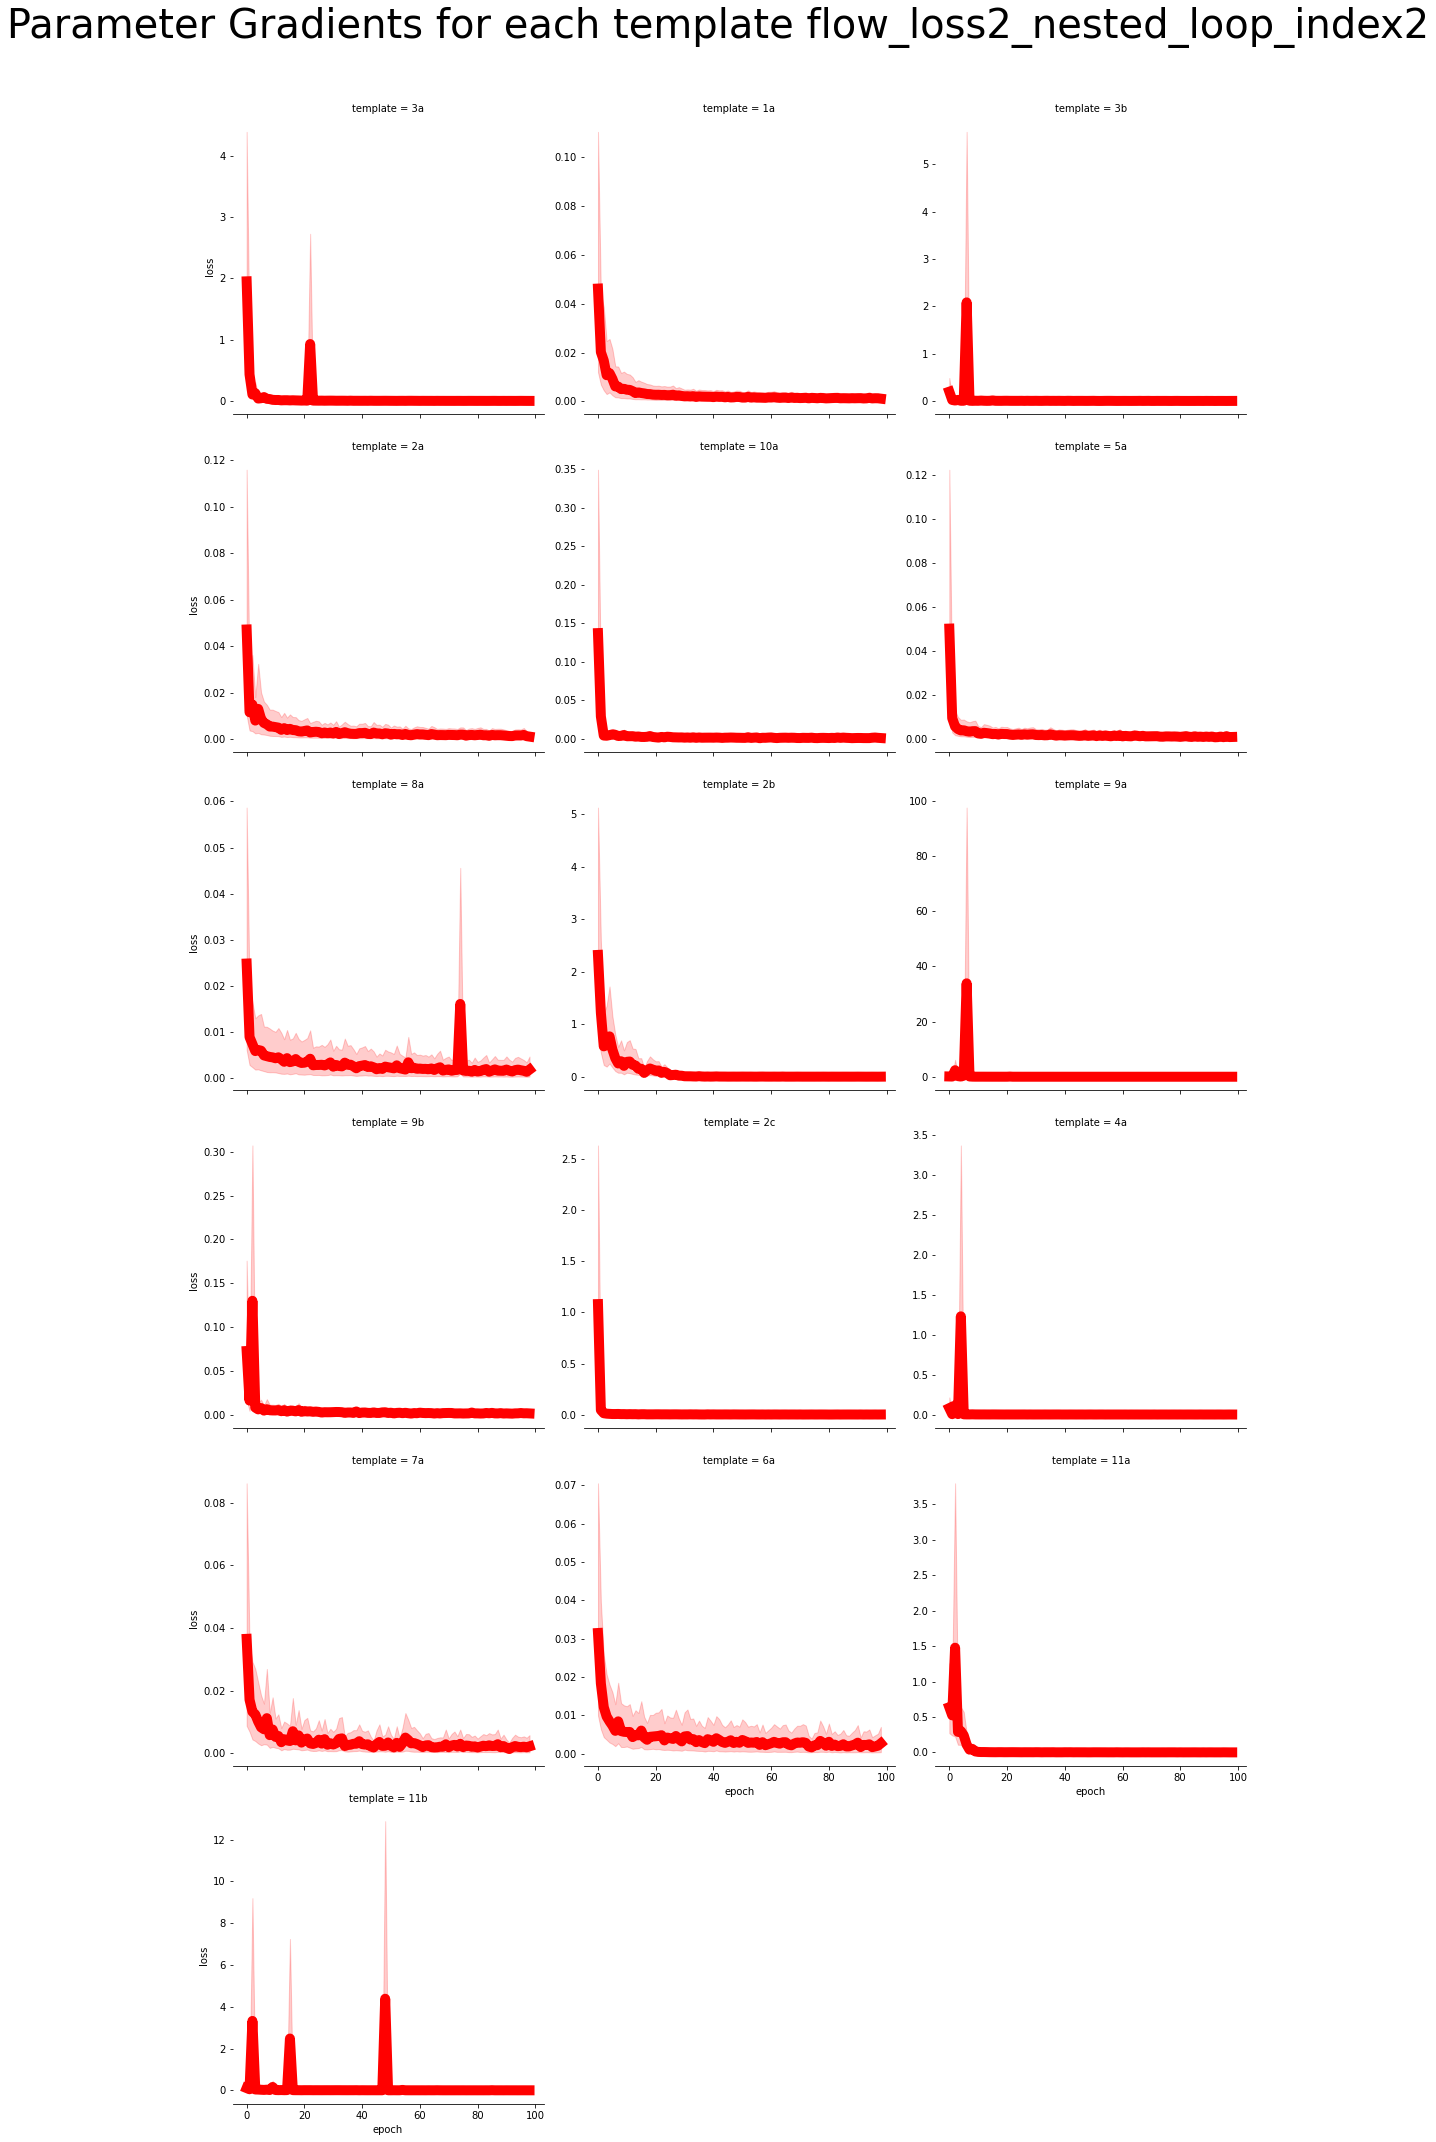

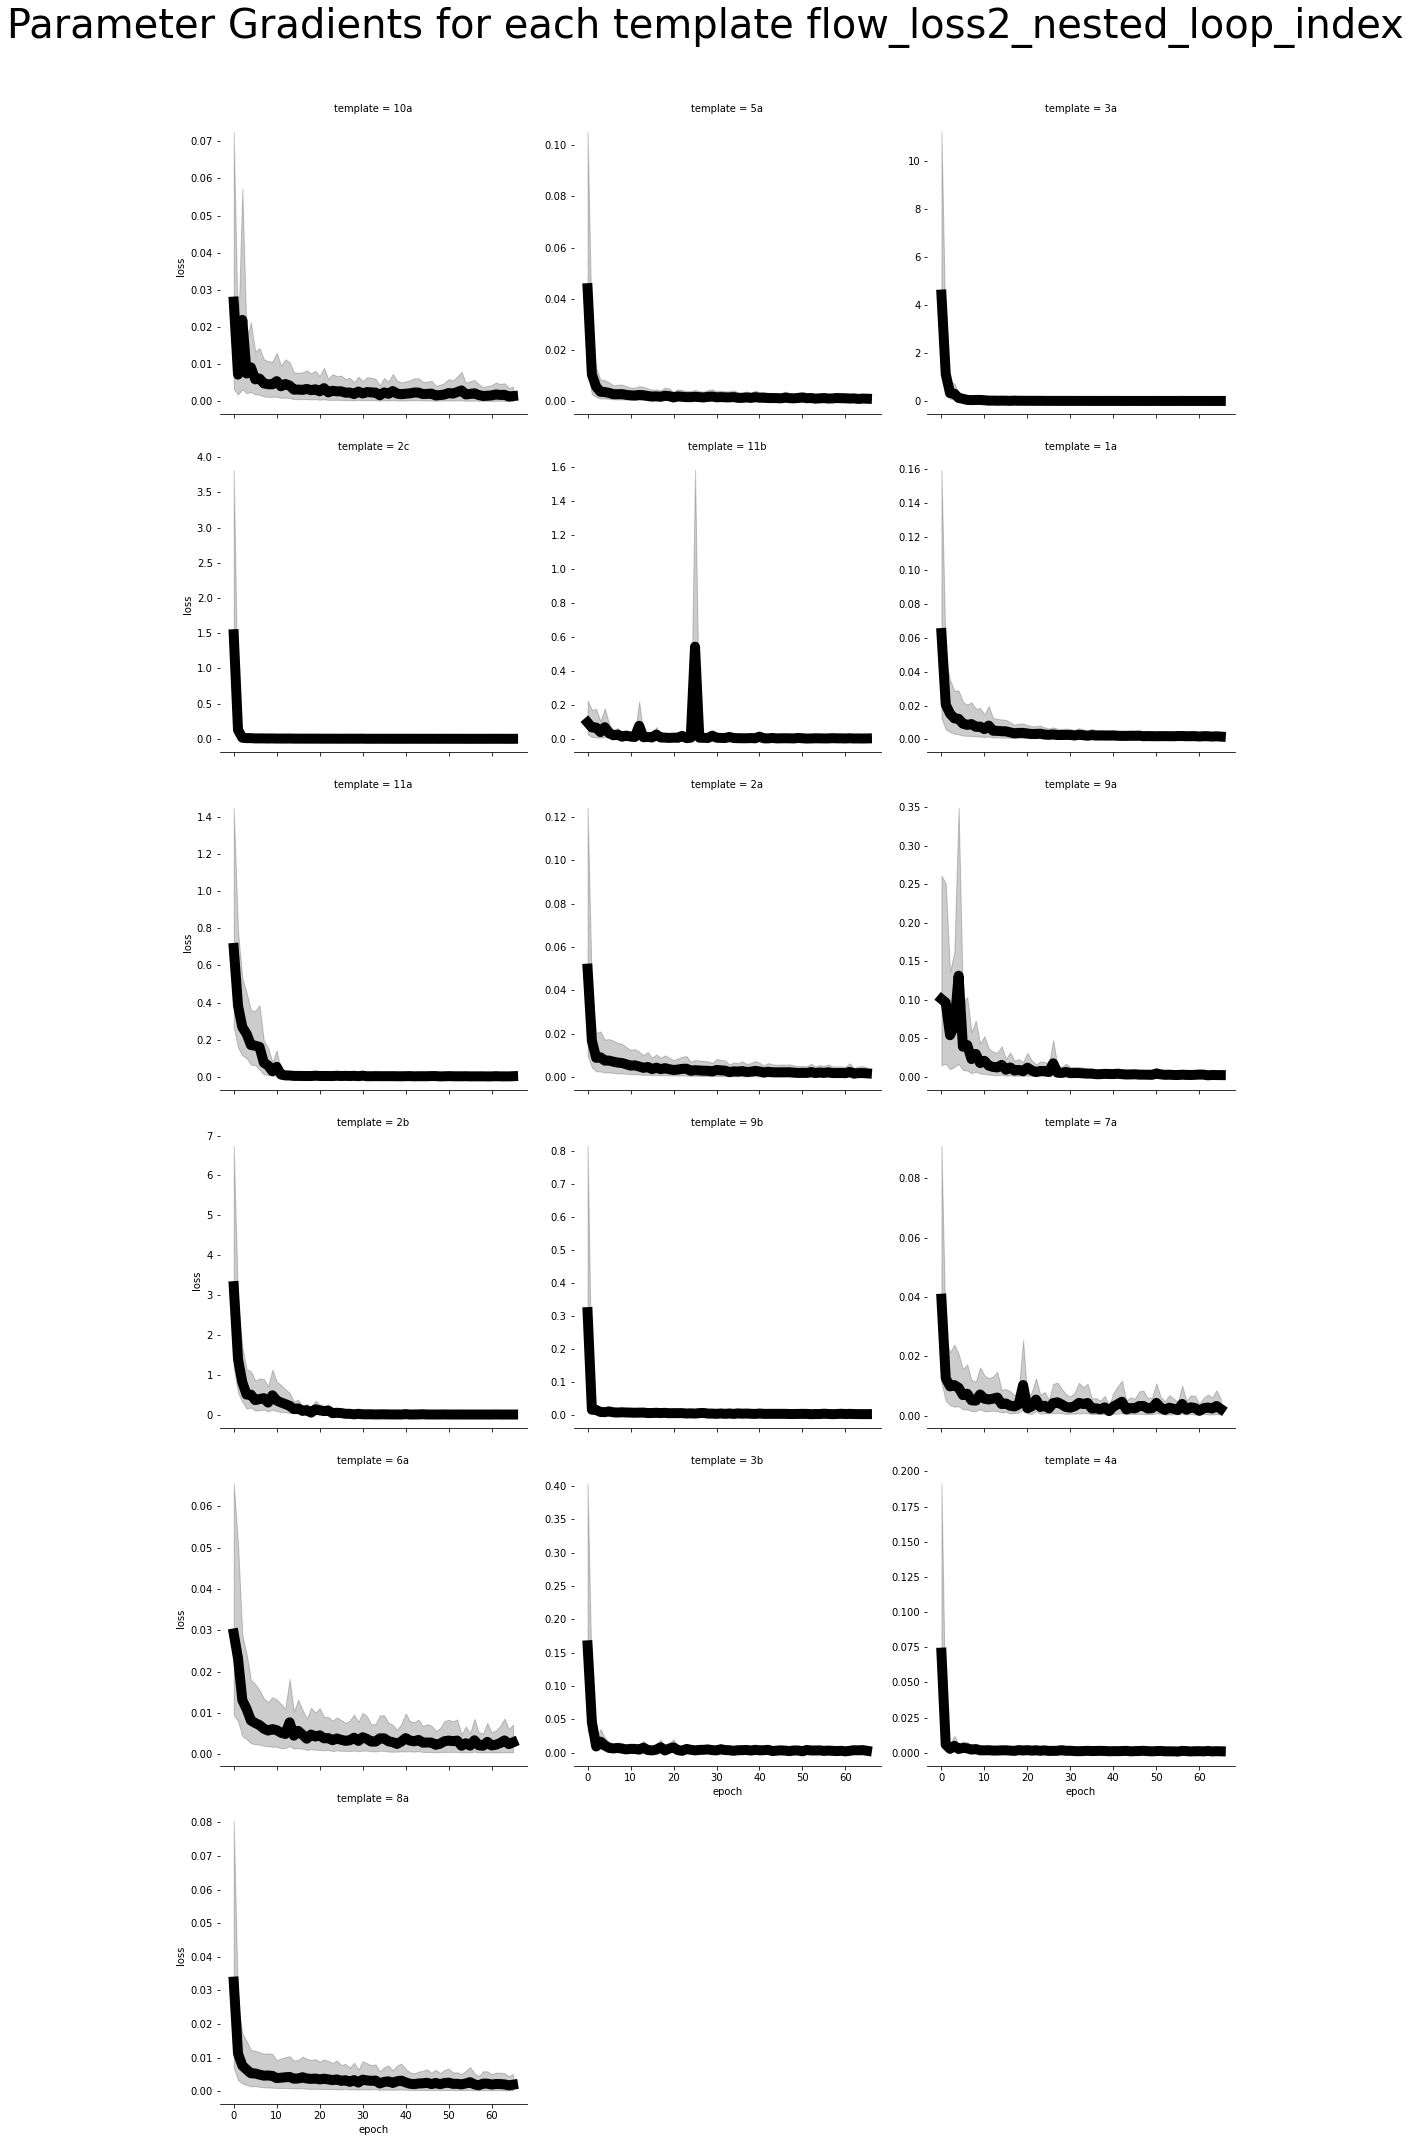

In [39]:
param_gradients =  [g for g in set(df["loss_type"]) if "param" in g]
param_gradients.sort()
par_grad_df = all_df[all_df["loss_type"].isin(param_gradients)]
algs = set(par_grad_df["alg_name"])
for alg in algs:
    plot_tmp_grad(par_grad_df, alg, HUE_COLORS=HUE_COLORS)

# Gradients wrt Model Output

* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step

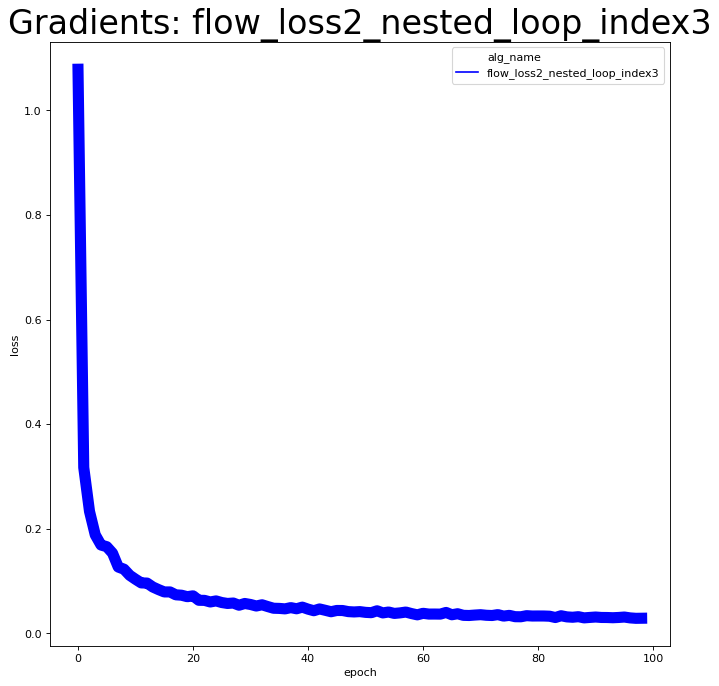

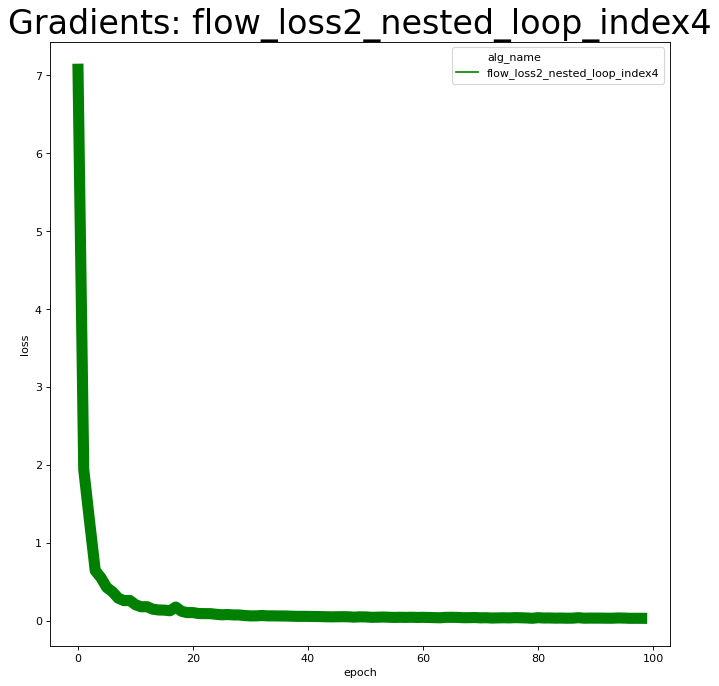

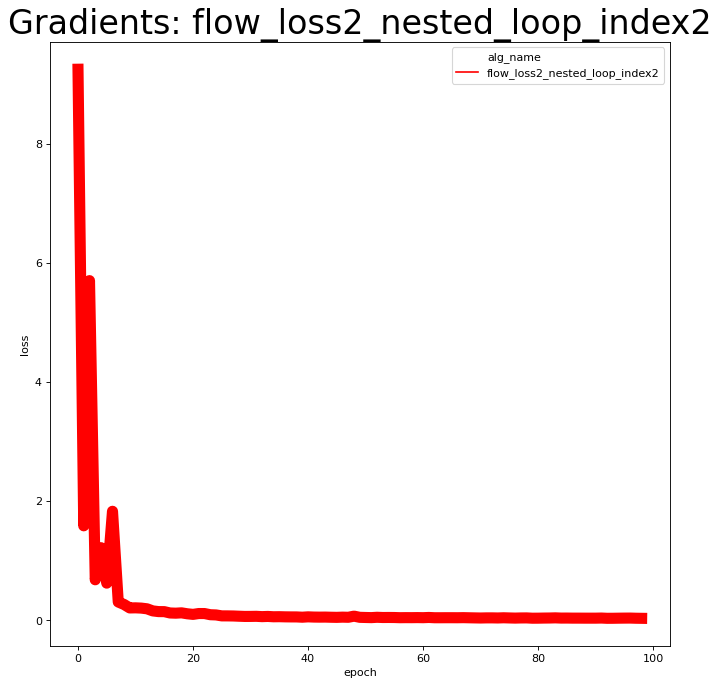

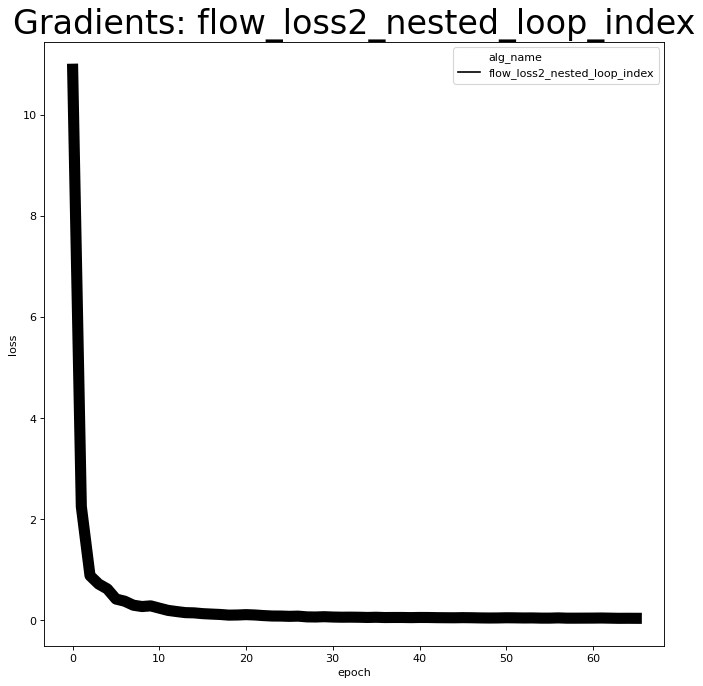

In [41]:
def plot_grad(df, alg_name, ylim):
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    cur_df = df[df["alg_name"] == alg_name]
    #cur_df = cur_df[cur_df["lr"] == lr]
    sns.lineplot(x="epoch", y="loss", data=cur_df, hue="alg_name", palette=HUE_COLORS, ci=None, 
                 linewidth=10.0)
    plt.ylim(ylim)
    alg_name = list(set(cur_df["alg_name"]))[0]
    plt.title("Gradients: " + alg_name, fontsize=30)
    #plt.yscale("log")
    plt.show()
    #plt.clf()

# Gradients
grad_df = df[df["loss_type"] == "gradients"]
algs = set(grad_df["alg_name"])
for alg in algs:
    plot_grad(grad_df, alg, (None, None))

# Loss Results

## Train - Test results over all the losses, and 6000+ queries each in the training / test sets

In [42]:
title_fmt = "Mean-{}-{}"
def plot_loss(df, loss_type, samples_type, yscale):

    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    if loss_type == "qerr":
        title = title_fmt.format("MSE", samples_type)
    else:
        title = title_fmt.format(loss_type, samples_type)
    plt.title(title, fontsize=50)
    cur_df = df[df["samples_type"] == samples_type]
    cur_df = cur_df[cur_df["loss_type"] == loss_type]
    
    scale_df = df[df["epoch"] == 4]
    scale_df = scale_df[scale_df["loss_type"] == loss_type]
    maxy = max(scale_df["loss"])
    miny = min(cur_df["loss"])
    #print(cur_df)
    sns.lineplot(x="epoch", y="loss", hue="alg_name", data=cur_df, palette=HUE_COLORS, ci=None)
    plt.ylim((miny,maxy))
    #plt.ylim((0,10000))
    plt.yscale(yscale)
    plt.rc('legend', fontsize=10, loc="lower left")    # legend fontsize
    plt.show()


template_title_fmt = "All-Templates-{}-{}"
def plot_loss_template(df, loss_type, samples_type, yscale):
    #if loss_type == "qerr":
        #title = template_title_fmt.format("MSE", samples_type)
    #else:
    
    title_name = ERROR_NAMES[loss_type]
    title = title_fmt.format(title_name, samples_type)

    loss_df = df[df["loss_type"] == loss_type]
    loss_df = loss_df[loss_df["samples_type"] == samples_type]
    scale_df = df[df["epoch"] == 4]
    scale_df = scale_df[scale_df["loss_type"] == loss_type]
    maxy = max(scale_df["loss"])
    miny = min(loss_df["loss"])
    #fig = plt.figure(figsize=(50, 50), dpi= 80, facecolor='w', edgecolor='k')
    fg = sns.relplot(x = "epoch", y = "loss", data=loss_df, col="template", col_wrap=3, 
                 facet_kws={'sharex':True, 'sharey':True},
                 hue="alg_name", palette=HUE_COLORS, linewidth=10.0, kind="line")
    fg.set(ylim=(miny,maxy))
    fg.set(yscale=yscale)
   # fg.fig.suptitle(title, fontsize=50)
    fg.fig.suptitle(title,
                x=0.5, y=.99, horizontalalignment='center',
                verticalalignment='top', fontsize = 40)
    fg.despine(left=True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

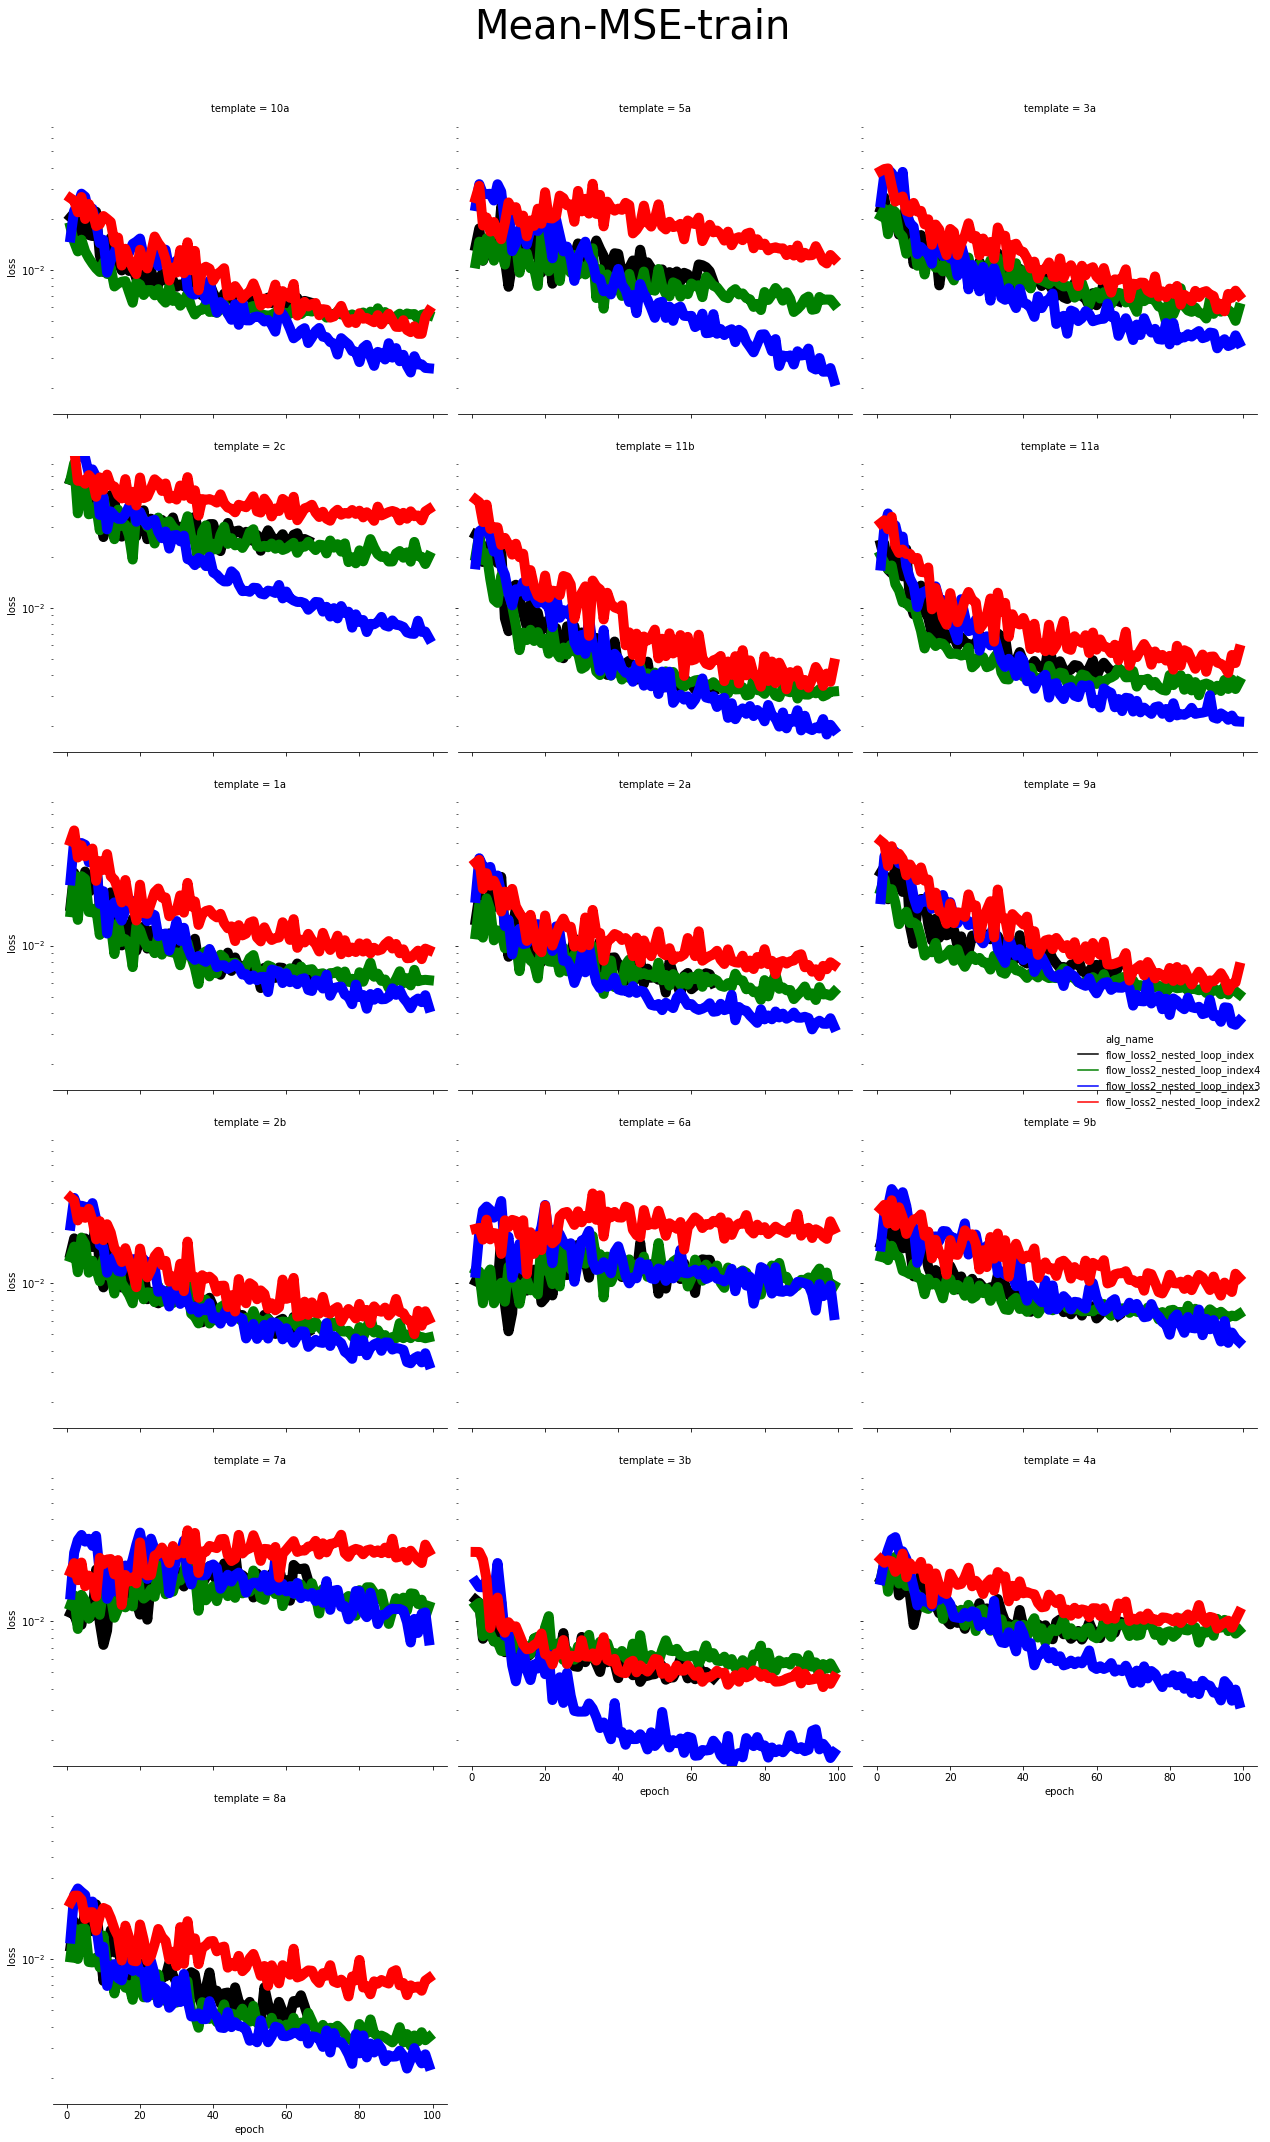

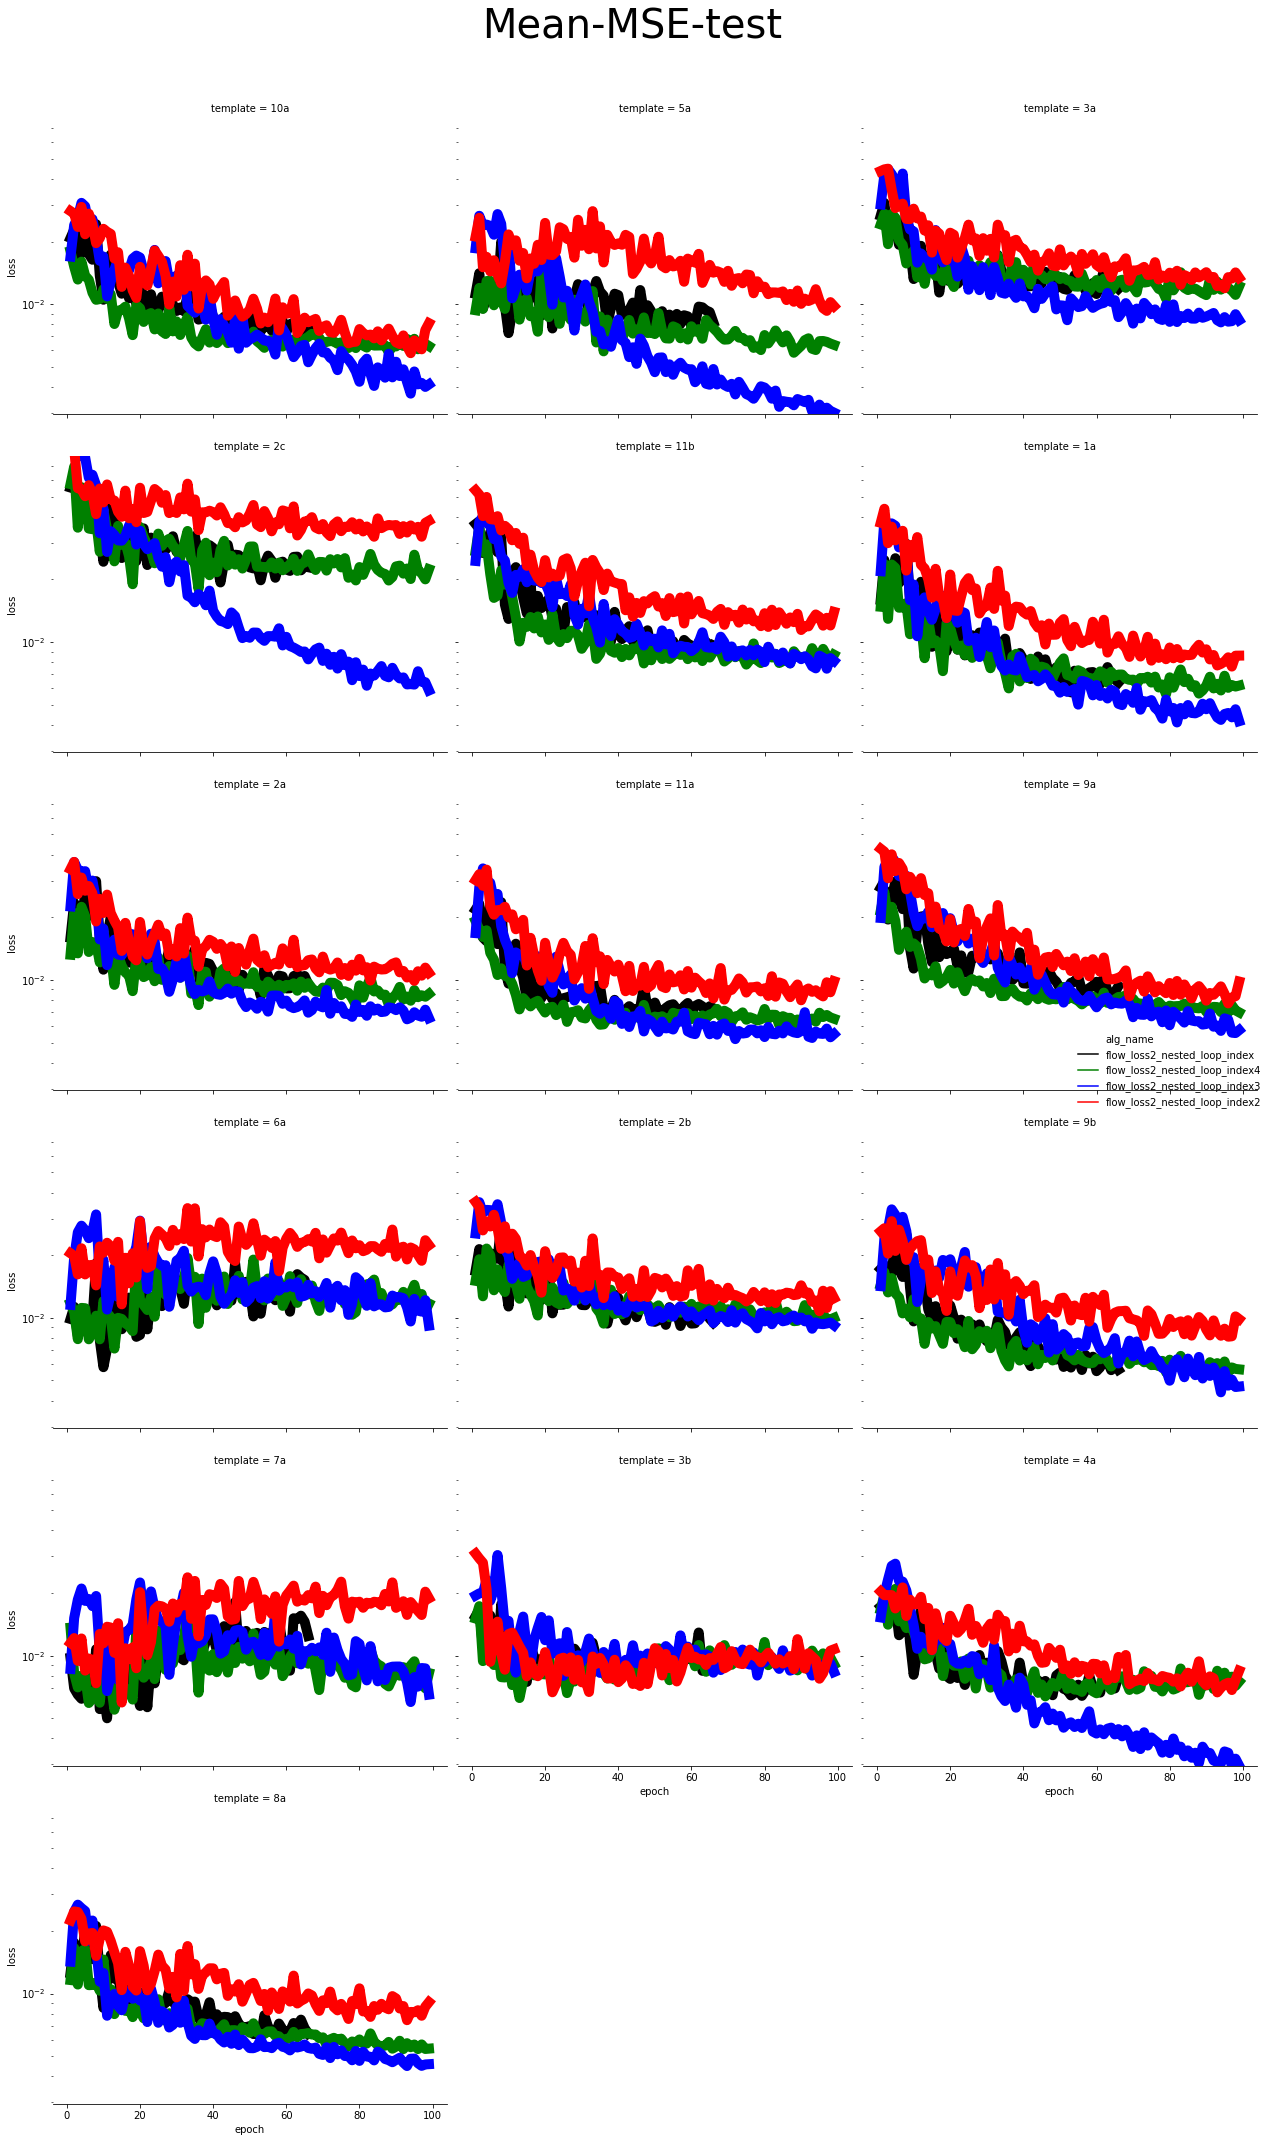

In [43]:
#plot_loss(df, "qerr", "train", "linear")
#plot_loss(df, "qerr", "test", "linear")
plot_loss_template(all_df, "qerr", "train", "log")
plot_loss_template(all_df, "qerr", "test", "log")


# Flow Error

## Flow_Loss - Optimal_Flow_loss

In [21]:
#plot_loss(df, "flow_err", "train", "linear")
#plot_loss(df, "flow_err", "test", "linear")
#plot_loss_template(all_df, "flow_err", "train", "log")
#plot_loss_template(all_df, "flow_err", "test", "log")

# Flow Ratio

## Flow_Loss / Optimal_Flow_loss

In [22]:
#plot_loss(df, "flow_ratio", "train", "linear")
#plot_loss(df, "flow_ratio", "test", "linear")
#plot_loss_template(all_df, "flow_ratio", "train", "log")
#plot_loss_template(all_df, "flow_ratio", "test", "log")

# MM1 Cost Model: Plan Error

## Simple Cost model that we used to define flow loss

## Plan Cost  - Optimal Plan Cost

In [23]:
#plot_loss(df, "mm1_plan_err", "train", "linear")
#plot_loss(df, "mm1_plan_err", "test", "linear")
#plot_loss_template(all_df, "mm1_plan_err", "train", "log")
#plot_loss_template(all_df, "mm1_plan_err", "test", "log")

# MM1 Cost Model: Plan Ratio

## Simple Cost model that we used to define flow loss

## Plan Cost  / Optimal Plan Cost

In [24]:
#plot_loss(df, "mm1_plan_ratio", "train", "linear")
#plot_loss(df, "mm1_plan_ratio", "test", "linear")
#plot_loss_template(all_df, "mm1_plan_ratio", "train", "log")
#plot_loss_template(all_df, "mm1_plan_ratio", "test", "log")

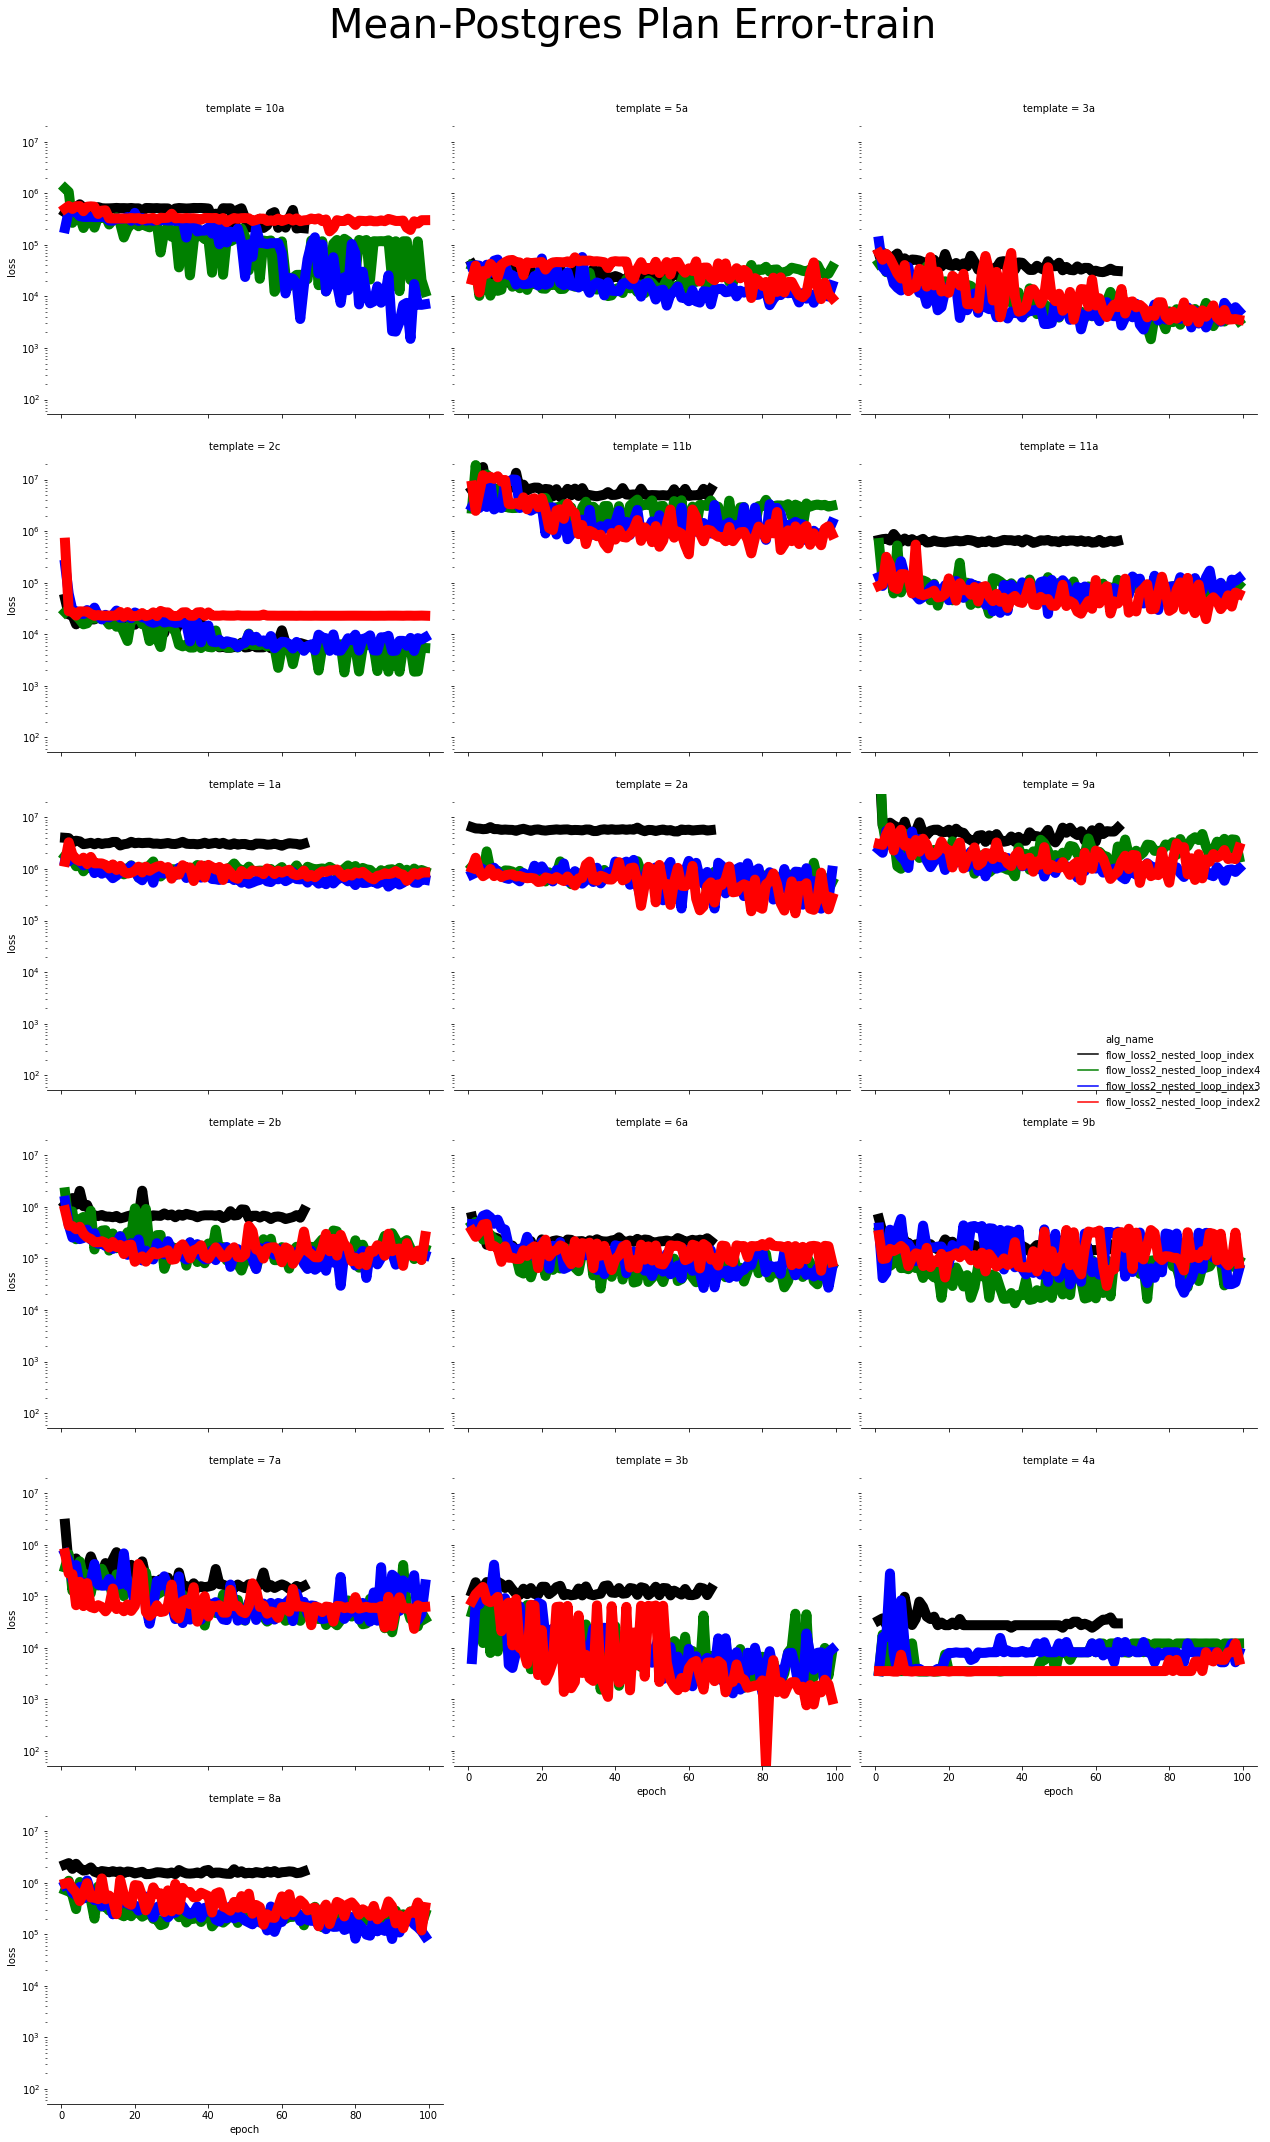

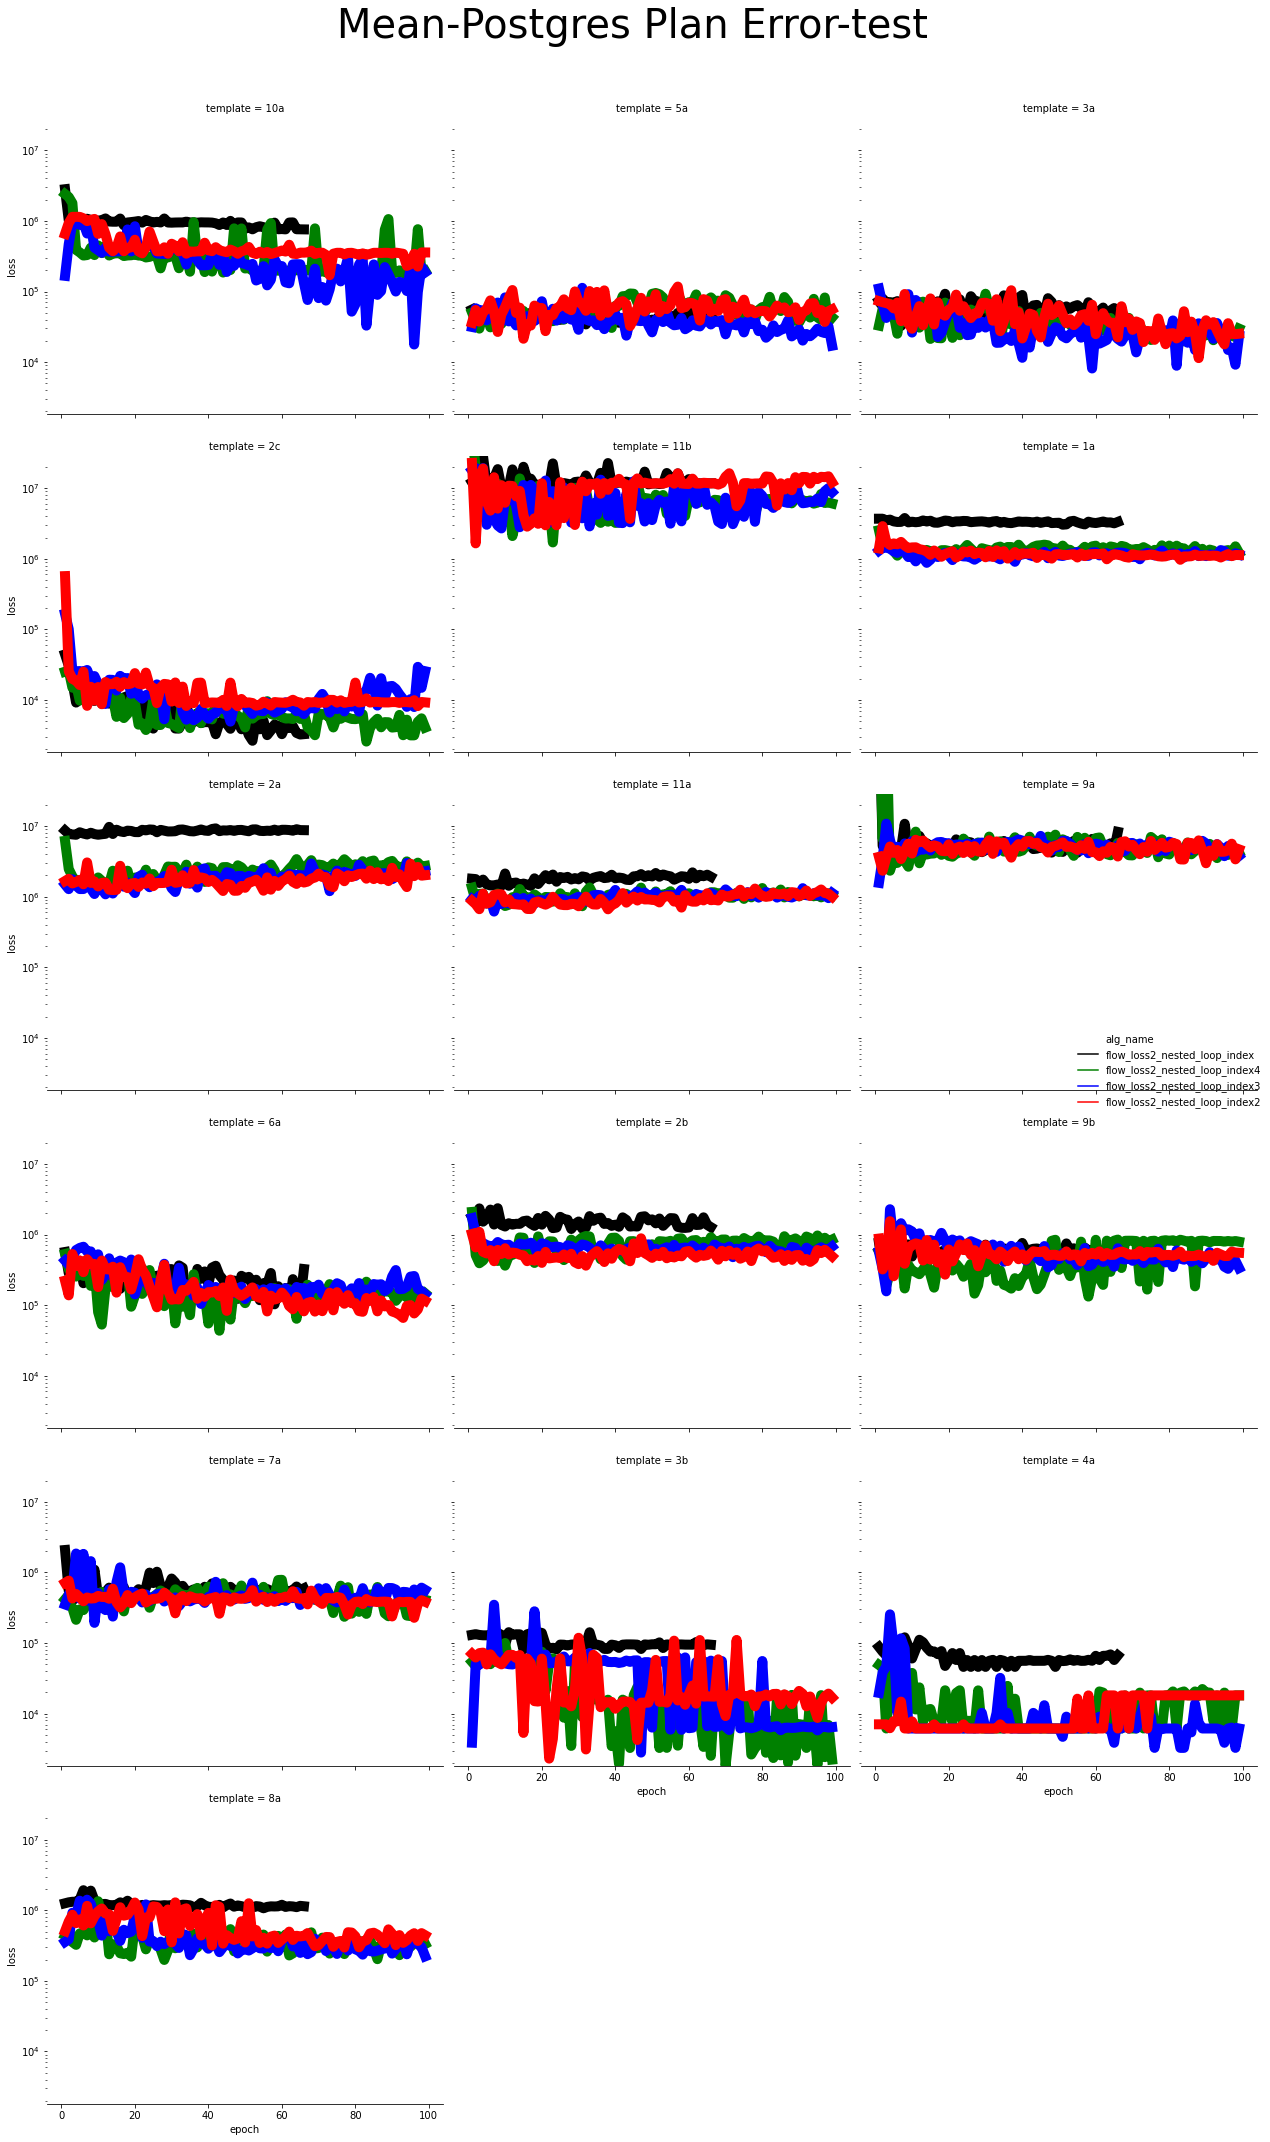

In [44]:
#plot_loss(df, "jerr", "train", "linear")
#plot_loss(df, "jerr", "test", "linear")
plot_loss_template(all_df, "jerr", "train", "log")
plot_loss_template(all_df, "jerr", "test", "log")

In [106]:
all_plans = get_all_plans(RES_DIR)

In [96]:
all_plans.keys()

Index(['epoch', 'query_name', 'jerr', 'plan', 'explain', 'qerr', 'alg', 'hls',
       'exp_name', 'priority'],
      dtype='object')